<a href="https://colab.research.google.com/github/Aleman-Z/StringerNeurons/blob/main/Stringer_stimulation_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependencies

## Loading of Stringer orientations data

includes some visualizations

In [ ]:
# @title Install depedencies
!pip install umap-learn --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data loading

dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [ ]:
# @title Reconstructing spontaneous period (not very useful since it has no speed data)

neural_data_spont=dat['u_spont'] @ dat['v_spont']
print(neural_data_spont.shape)

(23589, 910)


In [ ]:
# @title Dimensions of neural data during stimulation
print(dat['sresp'].shape)

(23589, 4598)


<ipython-input-101-facac8bc73e7>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


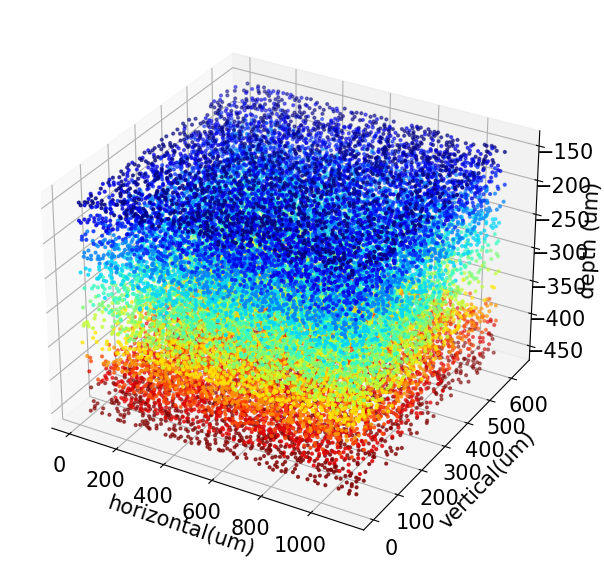

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1], y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

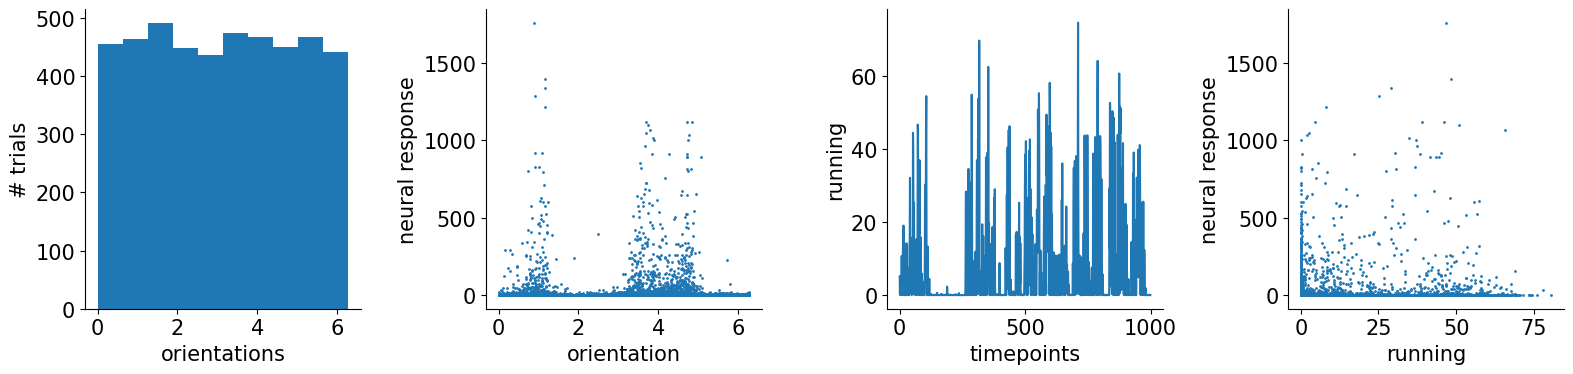

In [ ]:
# @title Basic data properties using plot, hist and scatter
ax = plt.subplot(1, 5, 1)
plt.hist(dat['istim'])
ax.set(xlabel='orientations', ylabel='# trials')

ax = plt.subplot(1, 5, 2)
plt.scatter(dat['istim'], dat['sresp'][200], s=1)
ax.set(xlabel='orientation', ylabel='neural response')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['run'][:1000])
ax.set(xlabel='timepoints', ylabel='running')

ax = plt.subplot(1, 5, 4)
plt.scatter(dat['run'], dat['sresp'][200], s=1)
ax.set(xlabel='running', ylabel='neural response')

plt.show()

(4598,)


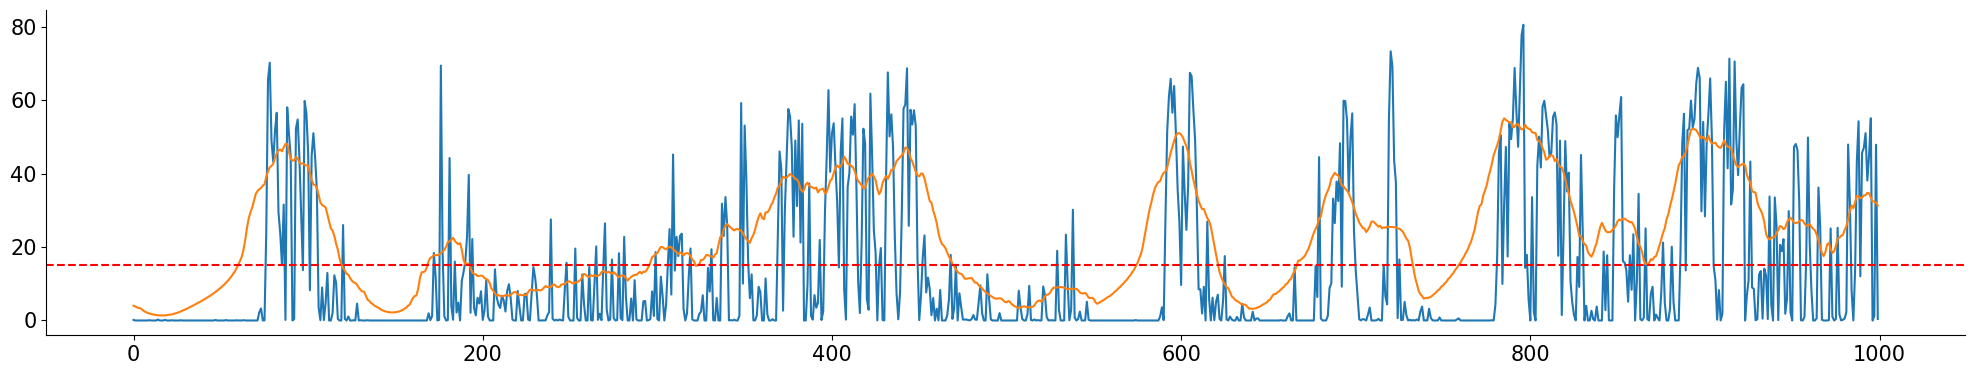

In [ ]:
# @title Smoothing running speed to identify high motion periods during stimuli condition (HMS).
run_data=dat['run']
print(run_data.shape)
plt.plot(run_data[2000:3000])
from scipy.signal import hilbert, convolve
analytic_signal = hilbert(run_data)
envelope = np.abs(analytic_signal)
window_size = 25
smoothed_envelope_HMS = convolve(envelope, np.ones(window_size) / window_size, mode='same')

plt.plot(smoothed_envelope_HMS[2000:3000])
# Add a horizontal line at Threshold
plt.axhline(y=15, color='r', linestyle='--', label='Horizontal Line at y=3')


Text(0.5, 1.0, 'Speed (raw and smoothed) during period of High motion activity')

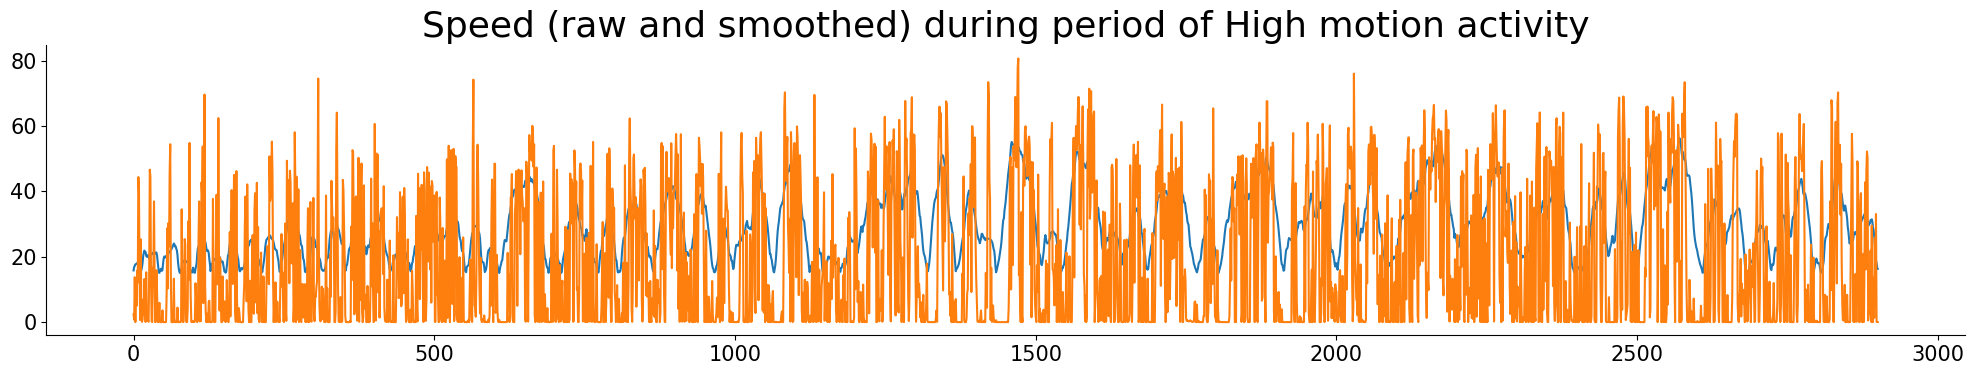

In [ ]:
# @title Thresholding speed to find high motion and low motion periods
threshold = 15
angle_data=dat['istim']

# Threshold the signal
above_threshold = smoothed_envelope_HMS > threshold
below_threshold= smoothed_envelope_HMS<=threshold

# Find the start and end indices of the periods above the threshold
start_indices = np.where(above_threshold & ~np.roll(above_threshold, 1))[0]
end_indices = np.where(above_threshold & ~np.roll(above_threshold, -1))[0]

start_indices_nonmotion = np.where(below_threshold & ~np.roll(below_threshold, 1))[0]
end_indices_nonmotion = np.where(below_threshold & ~np.roll(below_threshold, -1))[0]

# Handle edge case where the first or last point is above the threshold
if above_threshold[0]:
    start_indices = np.concatenate(([0], start_indices))
if above_threshold[-1]:
    end_indices = np.concatenate((end_indices, [len(smoothed_envelope_HMS) - 1]))

# Handle edge case where the first or last point is above the threshold
if below_threshold[0]:
    start_indices_nonmotion = np.concatenate(([0], start_indices_nonmotion))
if below_threshold[-1]:
    end_indices_nonmotion = np.concatenate((end_indices_nonmotion, [len(smoothed_envelope_HMS) - 1]))

# Create a concatenated signal with only the periods above the threshold
high_motion_smoothed_envelope = np.concatenate([smoothed_envelope_HMS[start:end+1] for start, end in zip(start_indices, end_indices)])
high_motion_run_data = np.concatenate([run_data[start:end+1] for start, end in zip(start_indices, end_indices)])
high_motion_angle_data = np.concatenate([angle_data[start:end+1] for start, end in zip(start_indices, end_indices)])



plt.plot(high_motion_smoothed_envelope)
plt.plot(high_motion_run_data)
plt.title('Speed (raw and smoothed) during period of High motion activity', fontsize=26)

(23589, 2901)
(23589,)


Text(0.5, 1.0, 'Mean activity across 23589 neurons during High motion period')

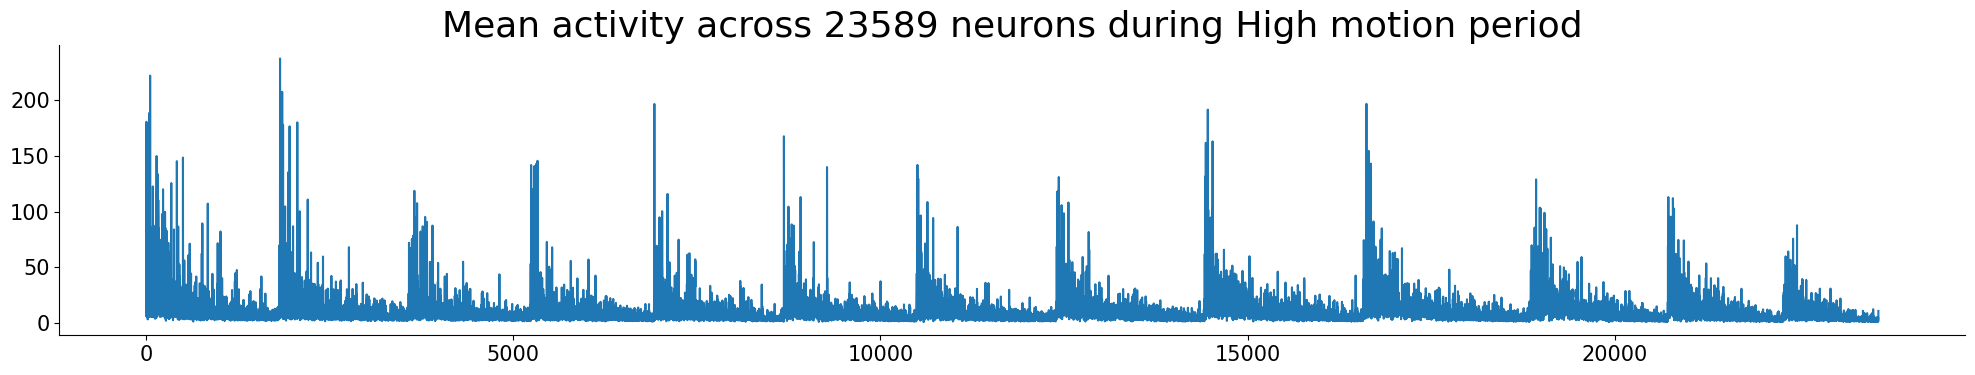

In [ ]:
# @title Extracting neural activity during high motion periods

neural_data=dat['sresp']
high_motion_neural_data = np.concatenate([neural_data[:, start:end+1] for start, end in zip(start_indices, end_indices)], axis=1)
print(high_motion_neural_data.shape)
high_motion_average=np.mean(high_motion_neural_data,axis=1)
print(high_motion_average.shape)
plt.plot(high_motion_average)
plt.title('Mean activity across 23589 neurons during High motion period', fontsize=26)

(23589, 1697)
(23589,)


Text(0.5, 1.0, 'Mean activity across 23589 neurons during Low motion period')

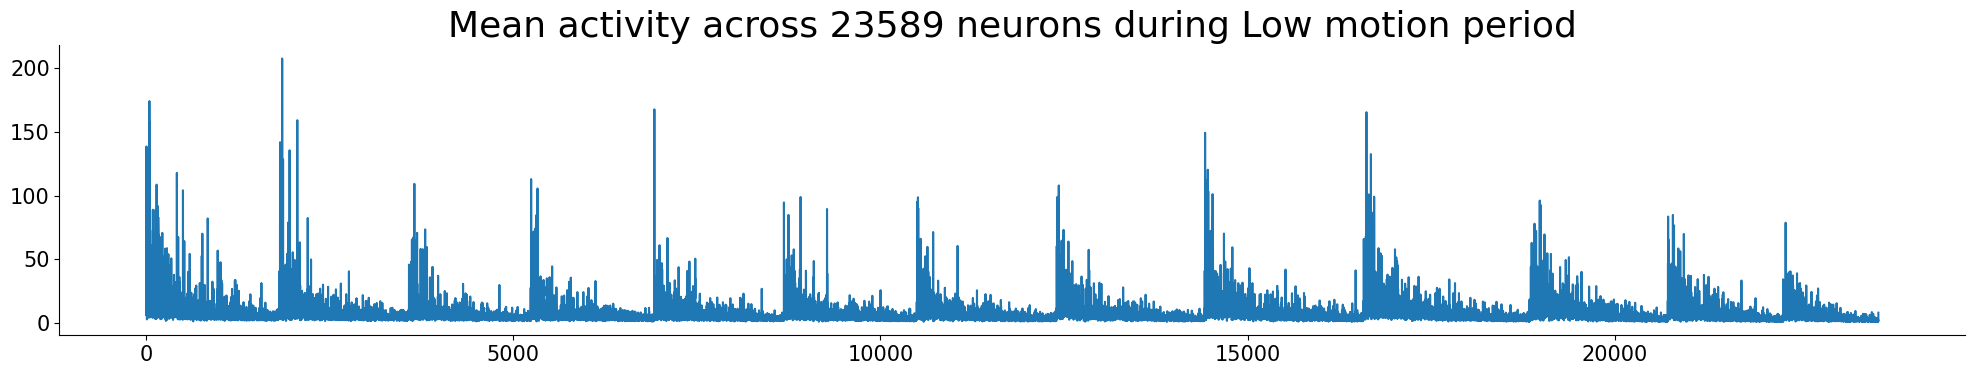

In [ ]:
angle_data=dat['istim']

non_motion_neural_data = np.concatenate([neural_data[:, start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=1)
non_motion_angle_data=np.concatenate([angle_data[start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=0)
non_motion_run_data=np.concatenate([run_data[start:end+1] for start, end in zip(start_indices_nonmotion, end_indices_nonmotion)], axis=0)

print(non_motion_neural_data.shape)
#plt.plot(high_motor_neural_data[0,:])
non_motion_average=np.mean(non_motion_neural_data,axis=1)
print(non_motion_average.shape)
plt.plot(non_motion_average)
plt.title('Mean activity across 23589 neurons during Low motion period', fontsize=26)

Text(0.5, 1.0, 'Cortical Depth (Z)')

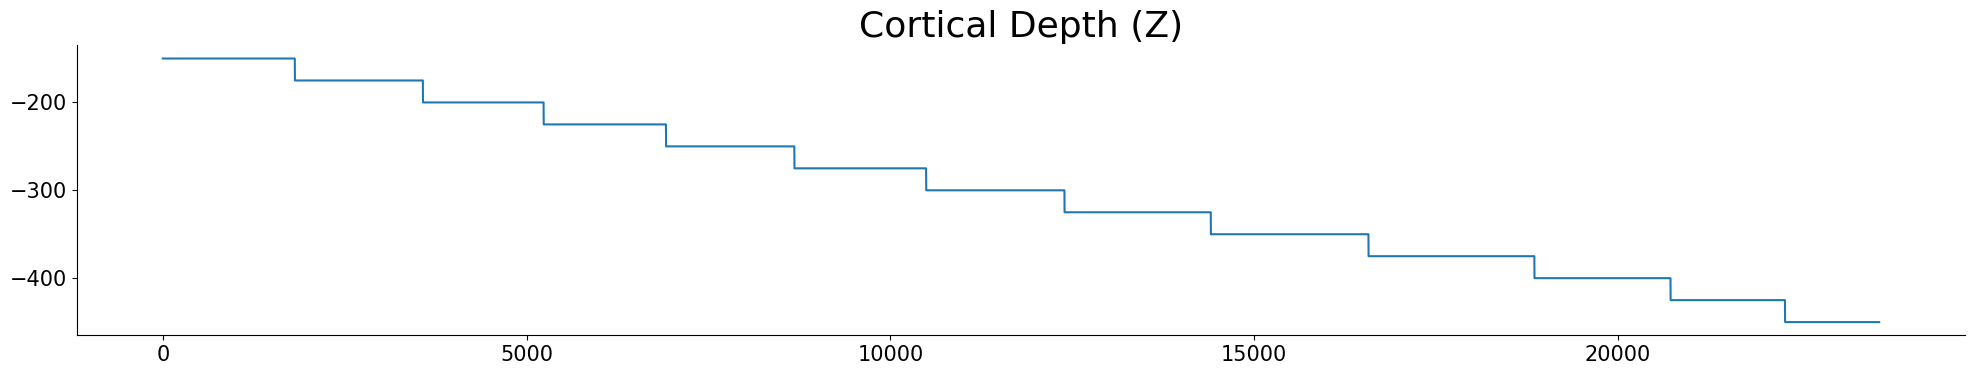

In [ ]:
plt.plot(z)
plt.title('Cortical Depth (Z)', fontsize=26)

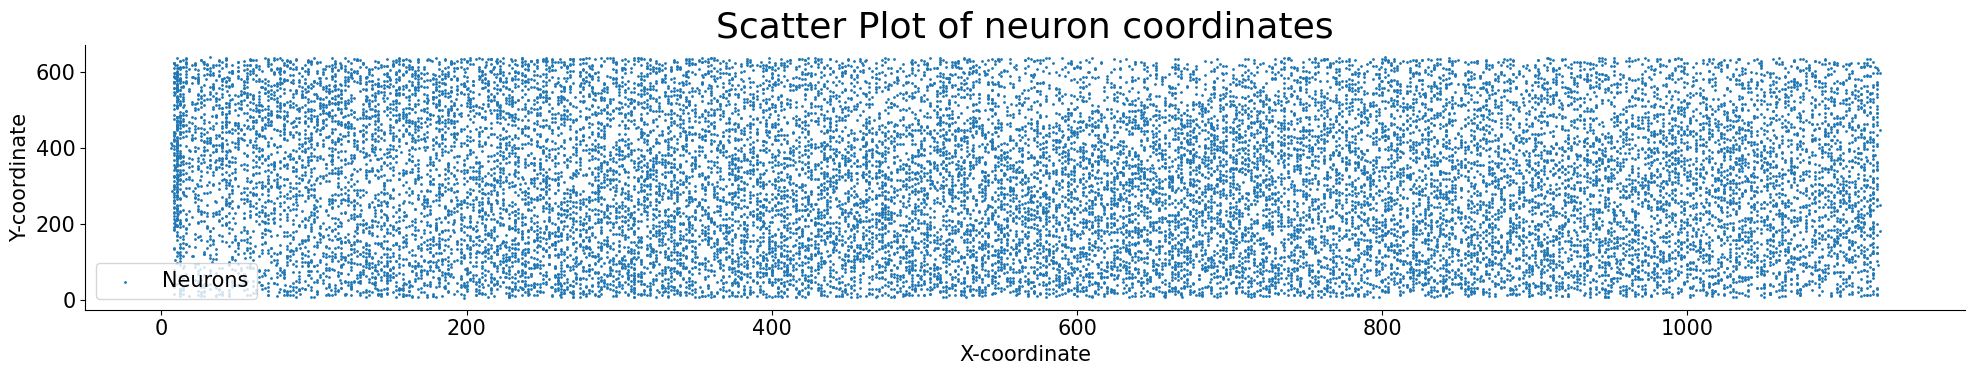

In [ ]:
# @title Distribution of X-Y coordinates

x,y,z=dat['xyz']
# Scatter plot of x-y coordinates
plt.scatter(x, y, label='Neurons',s=1)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Scatter Plot of neuron coordinates',fontsize=26)

# Show the plot
plt.legend()
plt.show()

(23589,)
[False False False ... False False False] 486


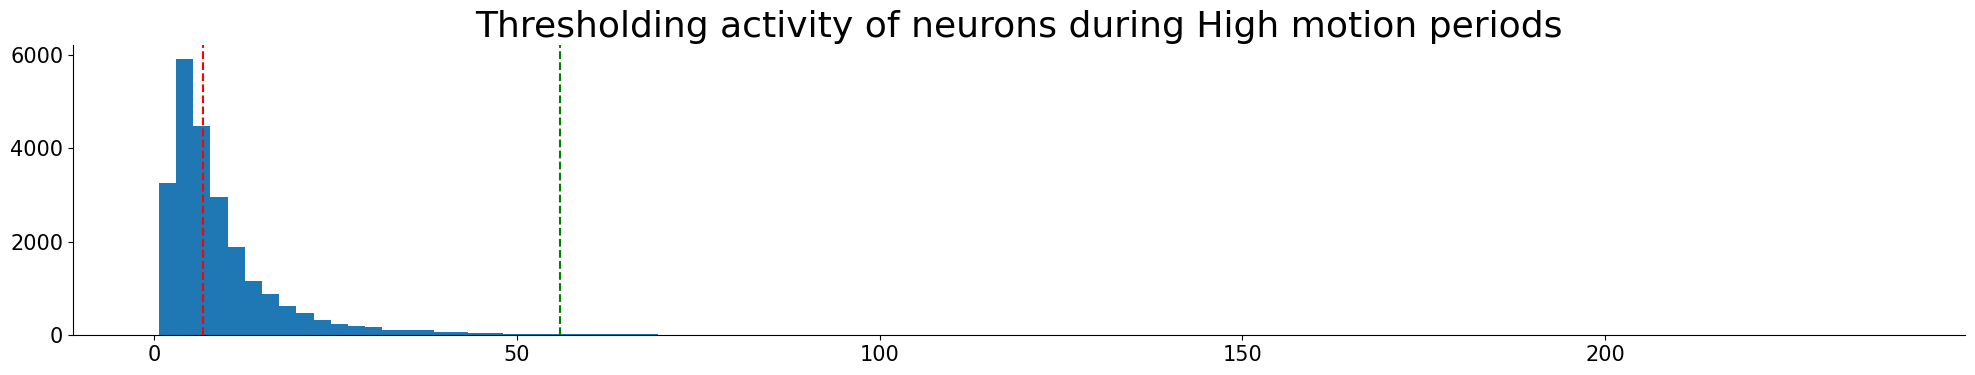

In [ ]:
# @title Finding neurons with high activity during High motion periods

plt.hist(high_motion_average,100)
plt.axvline(x=np.median(high_motion_average), color='r', linestyle='--', label='Vertical Line at y=25')
plt.axvline(x=np.median(high_motion_average)+np.std(high_motion_average)*4, color='g', linestyle='--', label='Vertical Line at y=25')
plt.title('Thresholding activity of neurons during High motion periods',fontsize=26)

threshold_motor_neurons=np.median(high_motion_average)+np.std(high_motion_average)*3
neurons_id=np.arange(0, 23590-1, 1)
print(neurons_id.shape)
# Threshold the neurons
above_threshold = high_motion_average > threshold_motor_neurons
print(above_threshold, np.sum(above_threshold))

motor_neurons=neurons_id[above_threshold]



(23589,)
[False False False ... False False False] 481


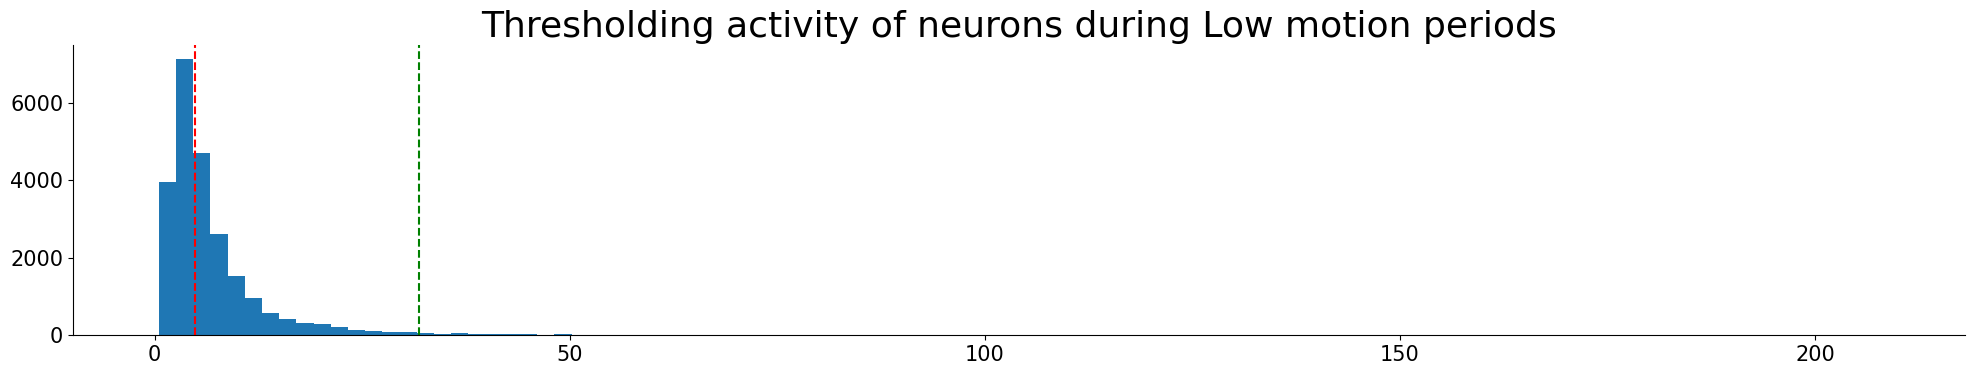

In [ ]:
# @title Finding neurons with high activity during Low motion periods

plt.hist(non_motion_average,100)
plt.axvline(x=np.median(non_motion_average), color='r', linestyle='--', label='Vertical Line at y=25')
plt.axvline(x=np.median(non_motion_average)+np.std(non_motion_average)*3, color='g', linestyle='--', label='Vertical Line at y=25')
plt.title('Thresholding activity of neurons during Low motion periods',fontsize=26)

threshold_non_motor_neurons=np.median(non_motion_average)+np.std(non_motion_average)*3
neurons_id_LMS=np.arange(0, 23590-1, 1)
print(neurons_id_LMS.shape)
# Threshold the neurons
above_threshold = non_motion_average > threshold_non_motor_neurons
print(above_threshold, np.sum(above_threshold))

LMS_neurons=neurons_id_LMS[above_threshold]

In [ ]:
# @title Finding common neurons in both High motion and Low motion periods
# Find common values
common_values = np.intersect1d(motor_neurons, LMS_neurons)
print(common_values.shape)
# Display the common values
#print("Common Values:", common_values)

# Find non-common values in array1
pure_motor_neurons = np.setdiff1d(motor_neurons, common_values)
print(pure_motor_neurons.shape)
#print(pure_motor_neurons)

pure_non_motor_neurons = np.setdiff1d(LMS_neurons, common_values)
print(pure_non_motor_neurons.shape)
#print(pure_non_motor_neurons)


(377,)
(109,)
(104,)


In [ ]:
pip install matplotlib_venn

In [ ]:
# @title remove common values to obtain pure motor neurons and pure non-motor neurons
LMS_neurons_wo_common = np.setdiff1d(LMS_neurons, common_values)
motor_neurons_wo_common = np.setdiff1d(motor_neurons, common_values)
print(len(LMS_neurons_wo_common))
print(len(motor_neurons_wo_common))
print(len(common_values))
total_number_neurons=len(LMS_neurons_wo_common)+len(motor_neurons_wo_common)+len(common_values)
print(total_number_neurons)

104
109
377
590


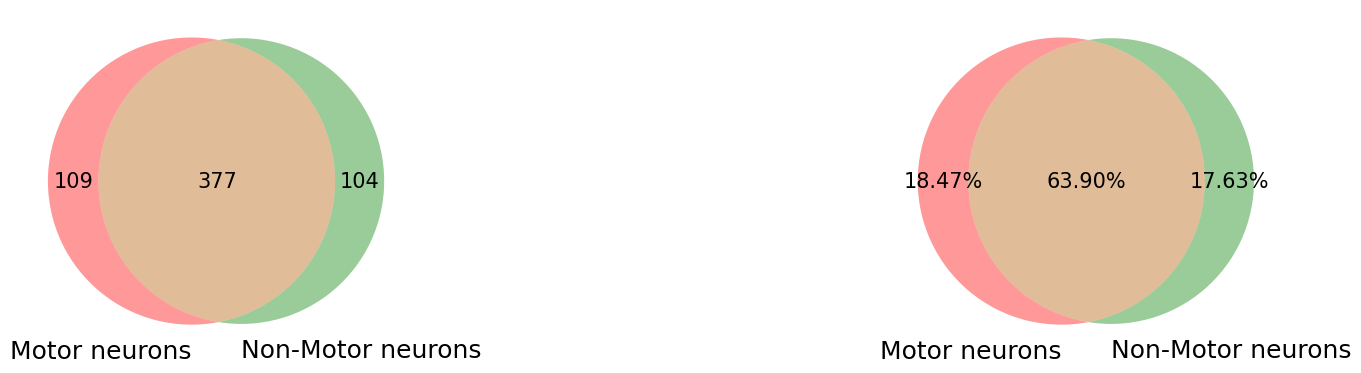

481


In [ ]:
# Set sizes of the groups in the Venn diagram
from matplotlib_venn import venn2
size_array1 = len(motor_neurons)
size_array2 = len(LMS_neurons)
size_common = len(common_values)

plt.subplot(1, 2, 1)
# Create a Venn diagram
venn2(subsets=(size_array1 - size_common, size_array2 - size_common, size_common),
      set_labels=('Motor neurons', 'Non-Motor neurons'))
plt.subplot(1, 2, 2)
venn2(subsets=(size_array1 - size_common, size_array2 - size_common, size_common),
      set_labels=('Motor neurons', 'Non-Motor neurons'),subset_label_formatter=lambda x: f"{ (x/total_number_neurons):1.2%}")

# Display the plot
plt.show()
print(len(LMS_neurons))

377 common neurons with high activity independently of speed

In [ ]:
Z = zscore(non_motion_neural_data[LMS_neurons_wo_common], axis=1)
Z.shape

(104, 1697)

In [ ]:
# @title take PCA to obtain PC per neuron group

Z = zscore(non_motion_neural_data[LMS_neurons_wo_common], axis=1)
#X_non_motor = PCA(n_components=20).fit_transform(Z.T)
# Create and fit the PCA model
pca = PCA(n_components=70)
X_non_motor = pca.fit_transform(Z.T)
# Get the explained variance from the PCA model
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))

Z = zscore(high_motion_neural_data[motor_neurons_wo_common], axis=1)
pca = PCA(n_components=70)
#X_motor = PCA(n_components=20).fit_transform(Z.T)
X_motor = pca.fit_transform(Z.T)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))

Z = zscore(non_motion_neural_data[common_values], axis=1)
pca = PCA(n_components=160)
#X_common_non_motor = PCA(n_components=20).fit_transform(Z.T)
X_common_non_motor = pca.fit_transform(Z.T)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))


Z = zscore(high_motion_neural_data[common_values], axis=1)
pca = PCA(n_components=160)
#X_common_motor = PCA(n_components=20).fit_transform(Z.T)
X_common_motor = pca.fit_transform(Z.T)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance cumulative sum:", np.cumsum(explained_variance))



Explained Variance cumulative sum: [0.07549098 0.13521237 0.1948263  0.23955464 0.27841574 0.31355723
 0.3412546  0.36733987 0.39256986 0.41337085 0.4319781  0.4501322
 0.46724053 0.48293826 0.49810683 0.51296766 0.52690788 0.54046968
 0.55319447 0.56576335 0.5778626  0.58933452 0.59994914 0.61038971
 0.62069377 0.63090175 0.64088148 0.65065493 0.66035034 0.66969031
 0.67873429 0.68766843 0.69642119 0.70490519 0.71331382 0.72156411
 0.72959652 0.73741426 0.74509665 0.75255528 0.75995987 0.76721662
 0.77422986 0.78113244 0.78798955 0.79459733 0.80108301 0.80723794
 0.81323381 0.8192291  0.82501893 0.83080198 0.83631822 0.84176297
 0.84713622 0.85248547 0.85756822 0.86252811 0.86744136 0.87228326
 0.87710328 0.88176338 0.88629685 0.89066657 0.89494462 0.89915319
 0.90327363 0.90723275 0.91113681 0.91499436]
Explained Variance cumulative sum: [0.09103938 0.16164763 0.21904572 0.25822922 0.29369262 0.3249647
 0.35455731 0.38273968 0.40438115 0.42591136 0.44455292 0.46249312
 0.47934507 0.4

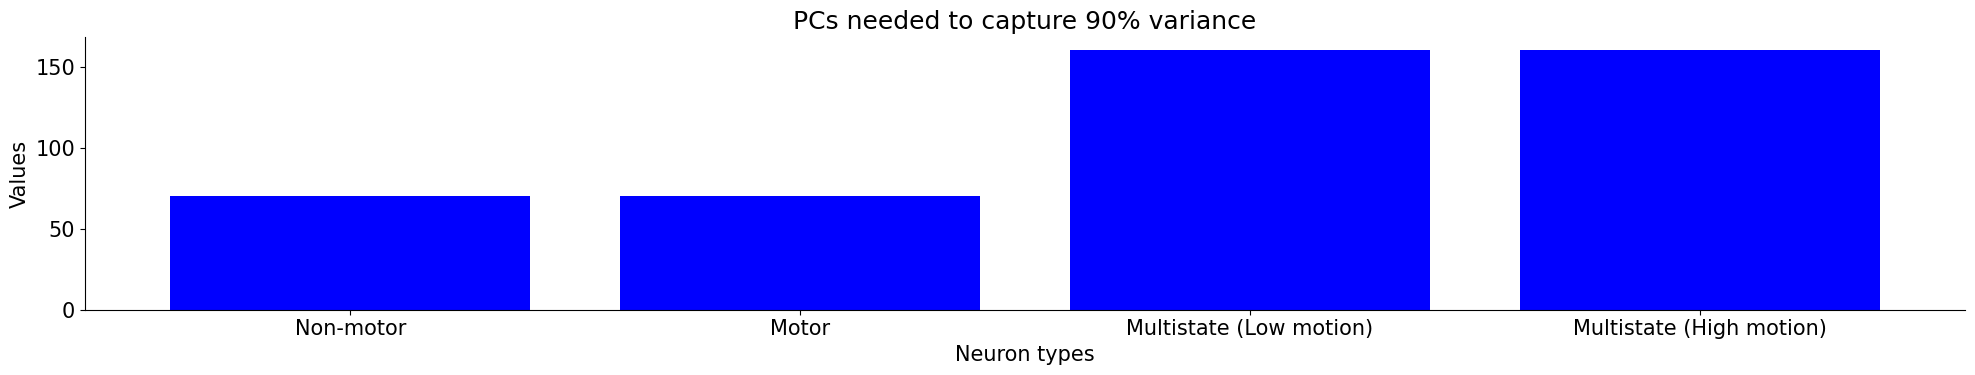

In [ ]:

# Sample data
categories = ['Non-motor', 'Motor', 'Multistate (Low motion)', 'Multistate (High motion)']
values1 = [70, 70, 160, 160]

# Create a bar plot
plt.bar(categories, values1, color='blue')

# Add labels and title
plt.xlabel('Neuron types')
plt.ylabel('Values')
plt.title('PCs needed to capture 90% variance')

# Display the plot
plt.show()



Multistate neurons have a higher complexity compared to non-motor and motor neurons.

4 PCA's:


*   Motor neurons (X_motor)
*   Non-motor neurons (X_non_motor)
*   Common neurons during High Motion periods (X_common_motor)
*   Common neurons during Low Motion periods (X_common_non_motor)




In [ ]:
#Motor
# @title Motor neurons: We iterate across the PCs to find the one with the highest correlation to the running speed
pc_highestcorr=0;
for i in range(X_motor.shape[1]):
  xx=np.abs(np.corrcoef(high_motion_run_data,X_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(high_motion_run_data,X_motor[:,pc_ind])[1,0])
X_motor_pc=X_motor[:,pc_ind]

0
0.6918564748282847


In [ ]:
print(X_motor.shape)
print(high_motion_run_data.shape)

(2901, 70)
(2901,)


In [ ]:
#Non-Motor
# @title Non-Motor neurons: We iterate across the PCs to find the one with the highest correlation to the stimulation angle
pc_highestcorr=0;
for i in range(X_non_motor.shape[1]):
  xx=np.abs(np.corrcoef(non_motion_angle_data,X_non_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(non_motion_angle_data,X_non_motor[:,pc_ind])[1,0])
X_non_motor_pc=X_non_motor[:,pc_ind]

1
0.3913163866835962


In [ ]:
print(X_non_motor.shape)
print(non_motion_angle_data.shape)

(1697, 70)
(1697,)


In [ ]:
#Motor
# @title Common neurons during High Motion period: We iterate across the PCs to find the one with the highest correlation to the running speed
pc_highestcorr=0;
for i in range(X_common_motor.shape[1]):
  xx=np.abs(np.corrcoef(high_motion_run_data,X_common_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(high_motion_run_data,X_common_motor[:,pc_ind])[1,0])
X_common_motor_pc=X_common_motor[:,pc_ind]

5
0.5227919820786097


In [ ]:
print(X_common_motor.shape)
print(high_motion_run_data.shape)

(2901, 160)
(2901,)


In [ ]:
#Non Motor
# @title Common neurons during Low Motion period: We iterate across the PCs to find the one with the highest correlation to the stimulation angle
pc_highestcorr=0;
for i in range(X_common_non_motor.shape[1]):
  xx=np.abs(np.corrcoef(non_motion_angle_data,X_common_non_motor[:,i])[1,0])
  #print(xx)
  if xx > pc_highestcorr:
    pc_highestcorr=xx
    pc_ind=i
print(pc_ind)
print(np.corrcoef(non_motion_angle_data,X_common_non_motor[:,pc_ind])[1,0])
X_common_non_motor_pc=X_common_non_motor[:,pc_ind]*-1 #Multiplied by -1 to reverse correlation sign

5
-0.3873228445841272


4 PC's per neuron type (Selected based on correlation with speed or angle):


*   Motor neurons (X_motor_pc)
*   Non-motor neurons (X_non_motor_pc)
*   Common neurons during High Motor periods (X_common_motor_pc)
*   Common neurons during Low Motor periods (X_common_non_motor_pc)



In [ ]:
print(X_motor_pc.shape)
print(X_non_motor_pc.shape)
print(X_common_motor_pc.shape)
print(X_common_non_motor_pc.shape)


(2901,)
(1697,)
(2901,)
(1697,)


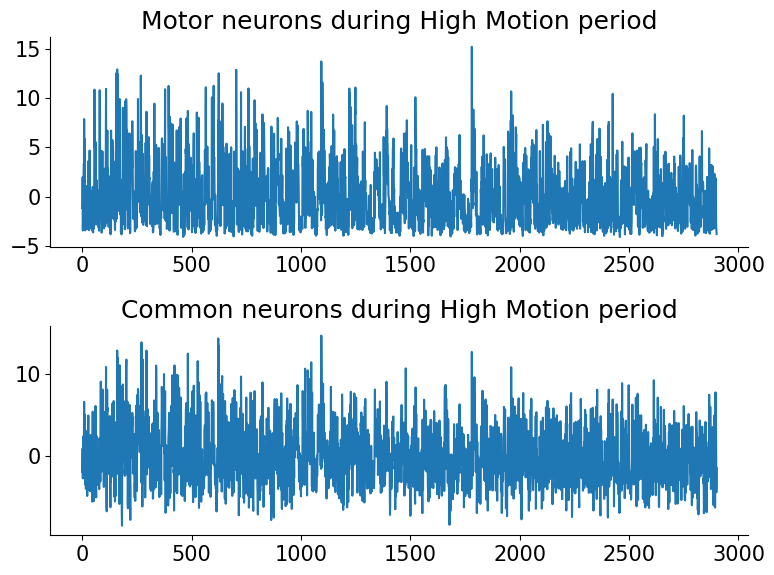

0.7182178952067616


In [ ]:
# @title Motor and common neurons during High motion period
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the data in the first subplot
axs[0].plot(X_motor_pc)
axs[0].set_title('Motor neurons during High Motion period')

# Plot the data in the second subplot
axs[1].plot(X_common_motor_pc)
axs[1].set_title('Common neurons during High Motion period')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
print(np.corrcoef(X_motor_pc,X_common_motor_pc)[1,0])

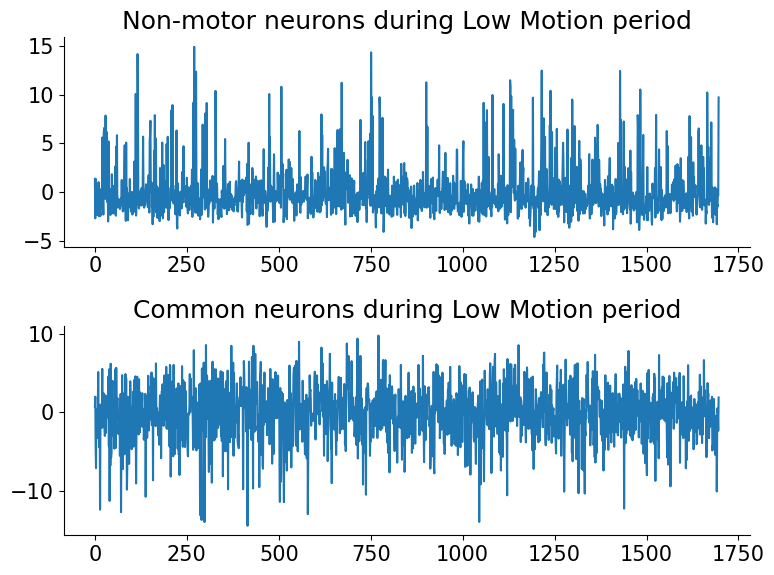

0.16646979424494504


In [ ]:
# @title Non-motor and common neurons during Low motion period
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot the data in the first subplot
axs[0].plot(X_non_motor_pc)
axs[0].set_title('Non-motor neurons during Low Motion period')

# Plot the data in the second subplot
axs[1].plot(X_common_non_motor_pc)
axs[1].set_title('Common neurons during Low Motion period')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
print(np.corrcoef(X_non_motor_pc,X_common_non_motor_pc)[1,0])

In [ ]:
# @title Functions to perform regression (Linear, polynomial ) and obtain null distribution
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

def linear_reg(X,y,num_splits=10):
  # Check if X is 1D, reshape if needed
  if len(X.shape) == 1:
        X = X.reshape(-1, 1)
  mse_values=[];
  for i in range(num_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)
    #print("X_train",X_train.shape)
    #print("y_train",y_train.shape)
    # Initialize and train the model
    model = LinearRegression()
    #model.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
    model.fit(X_train, y_train)

    # Make predictions on the test set
    #predictions = model.predict(X_test.reshape(-1, 1))
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mse_values.append(mse)
  #print(f"Mean Squared Error: {mse}")
  return(mse_values)


def poli_reg(X, y, degree,num_splits=10):
    # Check if X is 1D, reshape if needed
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    mse_values=[];
    for i in range(num_splits):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)

      # Create polynomial features
      poly = PolynomialFeatures(degree=degree)
      X_poly_train = poly.fit_transform(X_train)
      X_poly_test = poly.transform(X_test)

      # Train linear regression model
      model = LinearRegression()
      model.fit(X_poly_train, y_train)

      # Make predictions
      predictions = model.predict(X_poly_test)

      # Evaluate the model
      mse = mean_squared_error(y_test, predictions)
      mse_values.append(mse)
    return mse_values

def get_null(X_motor_pc):
  num_seeds = 10

  # List to store mean squared errors for each seed
  mse_null_X_motor_pc = []

  # Loop over different random seeds
  for seed_value in range(num_seeds):
      np.random.seed(seed_value)  # Set a different seed in each iteration
      shuffled_array = np.copy(X_motor_pc)  # Make a copy to keep the original array intact
      np.random.shuffle(shuffled_array)

      # Calculate mean squared error
      mse = mean_squared_error(X_motor_pc, shuffled_array)
      mse_null_X_motor_pc.append(mse)
  return mse_null_X_motor_pc


In [ ]:
# @title Compute regression for motor and common neurons during High-motion periods

def compute_models(high_motion_run_data,high_motion_angle_data, X_motor_pc):
  high_motion_combined = np.vstack((high_motion_run_data, high_motion_angle_data)).T # Run and angle combined data

  # List to store MSE values for each model
  mse_values = []

  mse_motor_lineal_run=linear_reg(high_motion_run_data,X_motor_pc)
  mse_values.append(('Linear RUN', np.median(mse_motor_lineal_run)))

  mse_motor_lineal_angle=linear_reg(high_motion_angle_data,X_motor_pc)
  mse_values.append(('Linear Angle', np.median(mse_motor_lineal_angle)))

  mse_motor_lineal_multinput=linear_reg(high_motion_combined,X_motor_pc)
  mse_values.append(('Linear Multi', np.median(mse_motor_lineal_multinput)))

  degree = 2
  mse_motor_poli2_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli2_run)))

  mse_motor_poli2_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli2_angle)))

  mse_motor_poli2_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli2_multinput)))


  degree = 3
  mse_motor_poli3_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli3_run)))

  mse_motor_poli3_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli3_angle)))

  mse_motor_poli3_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli3_multinput)))


  degree = 4
  mse_motor_poli4_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli4_run)))

  mse_motor_poli4_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli4_angle)))

  mse_motor_poli4_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli4_multinput)))


  degree = 5
  mse_motor_poli5_run = poli_reg(high_motion_run_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} RUN', np.median(mse_motor_poli5_run)))

  mse_motor_poli5_angle = poli_reg(high_motion_angle_data, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Angle', np.median(mse_motor_poli5_angle)))

  mse_motor_poli5_multinput = poli_reg(high_motion_combined, X_motor_pc, degree)
  mse_values.append((f'Poly {degree} Multi', np.median(mse_motor_poli5_multinput)))



  # Find the model with the minimum MSE
  best_model_name, min_mse = min(mse_values, key=lambda x: x[1])

  # Print or return the results
  print(f'The best model is: {best_model_name} with MSE: {min_mse}')



  return mse_values,mse_motor_lineal_run,mse_motor_lineal_angle, mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle,mse_motor_poli2_multinput,mse_motor_poli3_run,mse_motor_poli3_angle,mse_motor_poli3_multinput,mse_motor_poli4_run,mse_motor_poli4_angle,mse_motor_poli4_multinput,mse_motor_poli5_run,mse_motor_poli5_angle,mse_motor_poli5_multinput

print('motor neurons')
result=compute_models(high_motion_run_data,high_motion_angle_data, X_motor_pc)
mse_allmodels_motor_pc, mse_motor_lineal_run, mse_motor_lineal_angle,mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle,mse_motor_poli2_multinput,mse_motor_poli3_run,mse_motor_poli3_angle,mse_motor_poli3_multinput,mse_motor_poli4_run,mse_motor_poli4_angle,mse_motor_poli4_multinput,mse_motor_poli5_run,mse_motor_poli5_angle,mse_motor_poli5_multinput = result;
#mse_values,mse_motor_lineal_run,mse_motor_lineal_angle, mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle,mse_motor_poli2_multinput,mse_motor_poli3_run,mse_motor_poli3_angle,mse_motor_poli3_multinput,mse_motor_poli4_run,mse_motor_poli4_angle,mse_motor_poli4_multinput,mse_motor_poli5_run,mse_motor_poli5_angle,mse_motor_poli5_multinput

print('common neurons during high motion period')
result=compute_models(high_motion_run_data,high_motion_angle_data, X_common_motor_pc)
#mse_allmodels_common_motor_pc,mse_common_motor_lineal_singleinput, mse_common_motor_lineal_multinput, mse_common_motor_poli2_singleinput,mse_common_motor_poli2_multinput,mse_common_motor_poli3_singleinput,mse_common_motor_poli3_multinput,mse_common_motor_poli4_singleinput,mse_common_motor_poli4_multinput,mse_common_motor_poli5_singleinput,mse_common_motor_poli5_multinput = result;
mse_allmodels_common_motor_pc, mse_common_motor_lineal_run, mse_common_motor_lineal_angle,mse_common_motor_lineal_multinput, mse_common_motor_poli2_run,mse_common_motor_poli2_angle,mse_common_motor_poli2_multinput,mse_common_motor_poli3_run,mse_common_motor_poli3_angle,mse_common_motor_poli3_multinput,mse_common_motor_poli4_run,mse_common_motor_poli4_angle,mse_common_motor_poli4_multinput,mse_common_motor_poli5_run,mse_common_motor_poli5_angle,mse_common_motor_poli5_multinput = result;


print('common neurons during low motion period')
result=compute_models(non_motion_run_data, non_motion_angle_data, X_common_non_motor_pc)
#mse_allmodels_common_non_motor_pc,mse_common_non_motor_lineal_singleinput, mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_singleinput,mse_common_non_motor_poli2_multinput,mse_common_non_motor_poli3_singleinput,mse_common_non_motor_poli3_multinput,mse_common_non_motor_poli4_singleinput,mse_common_non_motor_poli4_multinput,mse_common_non_motor_poli5_singleinput,mse_common_non_motor_poli5_multinput = result;
mse_allmodels_common_non_motor_pc, mse_common_non_motor_lineal_run, mse_common_non_motor_lineal_angle,mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_run,mse_common_non_motor_poli2_angle,mse_common_non_motor_poli2_multinput,mse_common_non_motor_poli3_run,mse_common_non_motor_poli3_angle,mse_common_non_motor_poli3_multinput,mse_common_non_motor_poli4_run,mse_common_non_motor_poli4_angle,mse_common_non_motor_poli4_multinput,mse_common_non_motor_poli5_run,mse_common_non_motor_poli5_angle,mse_common_non_motor_poli5_multinput = result;


print('non-motor neurons during low motion period')
result=compute_models(non_motion_run_data, non_motion_angle_data,X_non_motor_pc)
#mse_allmodels_non_motor_pc,mse_non_motor_lineal_singleinput, mse_non_motor_lineal_multinput, mse_non_motor_poli2_singleinput,mse_non_motor_poli2_multinput,mse_non_motor_poli3_singleinput,mse_non_motor_poli3_multinput,mse_non_motor_poli4_singleinput,mse_non_motor_poli4_multinput,mse_non_motor_poli5_singleinput,mse_non_motor_poli5_multinput = result;
mse_allmodels_non_motor_pc, mse_non_motor_lineal_run, mse_non_motor_lineal_angle,mse_non_motor_lineal_multinput, mse_non_motor_poli2_run,mse_non_motor_poli2_angle,mse_non_motor_poli2_multinput,mse_non_motor_poli3_run,mse_non_motor_poli3_angle,mse_non_motor_poli3_multinput,mse_non_motor_poli4_run,mse_non_motor_poli4_angle,mse_non_motor_poli4_multinput,mse_non_motor_poli5_run,mse_non_motor_poli5_angle,mse_non_motor_poli5_multinput = result;



motor neurons
The best model is: Poly 5 Multi with MSE: 3.826427255920559
common neurons during high motion period
The best model is: Poly 5 Multi with MSE: 6.464288752947372
common neurons during low motion period
The best model is: Poly 4 Multi with MSE: 6.748770229277991
non-motor neurons during low motion period
The best model is: Poly 5 Angle with MSE: 3.6587701513429582


In [ ]:
mse_allmodels_motor_pc

[('Linear RUN', 4.888998841910243),
 ('Linear Angle', 9.77871251756568),
 ('Linear Multi', 4.873683663513223),
 ('Poly 2 RUN', 4.22670765147905),
 ('Poly 2 Angle', 9.760845374481946),
 ('Poly 2 Multi', 4.1367316099179865),
 ('Poly 3 RUN', 4.160895498808078),
 ('Poly 3 Angle', 9.83741741336424),
 ('Poly 3 Multi', 4.024407216600867),
 ('Poly 4 RUN', 4.203148353987686),
 ('Poly 4 Angle', 9.583157464727748),
 ('Poly 4 Multi', 3.8872973569859344),
 ('Poly 5 RUN', 4.411956305542339),
 ('Poly 5 Angle', 9.604945383876153),
 ('Poly 5 Multi', 3.826427255920559)]

Notice how training Motor neurons with only with the ANGLE led to high error values. Combined ANGLE+RUN reduced the errors.



In [ ]:
mse_allmodels_non_motor_pc

[('Linear RUN', 6.580681197432428),
 ('Linear Angle', 5.57933128257846),
 ('Linear Multi', 5.5809531381261035),
 ('Poly 2 RUN', 6.594786807243965),
 ('Poly 2 Angle', 5.075597987682906),
 ('Poly 2 Multi', 5.083313314533868),
 ('Poly 3 RUN', 6.595199351899117),
 ('Poly 3 Angle', 4.962723767538733),
 ('Poly 3 Multi', 4.978196563980733),
 ('Poly 4 RUN', 6.594340265752838),
 ('Poly 4 Angle', 4.969844863196924),
 ('Poly 4 Multi', 4.956762311907614),
 ('Poly 5 RUN', 6.600395193398473),
 ('Poly 5 Angle', 3.6587701513429582),
 ('Poly 5 Multi', 3.6702564421483483)]

Notice how training Non-motor neurons only with RUN led to high error values. Adding combined Angle+RUN worsens predictions.

In [ ]:
mse_allmodels_common_motor_pc

[('Linear RUN', 9.18506268100081),
 ('Linear Angle', 12.79497288496021),
 ('Linear Multi', 9.079558946219588),
 ('Poly 2 RUN', 8.469101698722767),
 ('Poly 2 Angle', 11.413536290850297),
 ('Poly 2 Multi', 6.779471989922765),
 ('Poly 3 RUN', 8.416072644535026),
 ('Poly 3 Angle', 11.39023007590004),
 ('Poly 3 Multi', 6.652893032060318),
 ('Poly 4 RUN', 8.431061870492776),
 ('Poly 4 Angle', 11.2189112073482),
 ('Poly 4 Multi', 6.5648147985162515),
 ('Poly 5 RUN', 8.690980963477392),
 ('Poly 5 Angle', 11.232555054163402),
 ('Poly 5 Multi', 6.464288752947372)]

Common neurons during High motion periods show a high error when using only Angle. Combining Angle+RUN led to an improvement.

In [ ]:
mse_allmodels_common_non_motor_pc

[('Linear RUN', 11.951404036229997),
 ('Linear Angle', 10.60547066174464),
 ('Linear Multi', 10.540936271874617),
 ('Poly 2 RUN', 11.939257949036772),
 ('Poly 2 Angle', 8.607859720986234),
 ('Poly 2 Multi', 8.321939417273747),
 ('Poly 3 RUN', 11.951122612600734),
 ('Poly 3 Angle', 6.962975989841372),
 ('Poly 3 Multi', 6.777951259866935),
 ('Poly 4 RUN', 11.994446215342558),
 ('Poly 4 Angle', 6.9336030113234095),
 ('Poly 4 Multi', 6.748770229277991),
 ('Poly 5 RUN', 11.937934448263665),
 ('Poly 5 Angle', 6.936269274212517),
 ('Poly 5 Multi', 6.846133260867704)]

Notice how Common neurons during Low motion period show a higher error when only RUN is used. Combining RUN+Angle led to improvements.

In [ ]:
# @title Null distributions
mse_null_X_motor_pc=get_null(X_motor_pc)
mse_null_X_common_motor_pc=get_null(X_common_motor_pc)
mse_null_X_common_non_motor_pc=get_null(X_common_non_motor_pc)
mse_null_X_non_motor_pc=get_null(X_non_motor_pc)

print('Null error Motor neurons:',np.median(mse_null_X_motor_pc))
print('Null error Common neurons during High motion:',np.median(mse_null_X_common_motor_pc))
print('Null error Common neurons during Low motion:',np.median(mse_null_X_common_non_motor_pc))
print('Null error Non-Motor neurons:',np.median(mse_null_X_non_motor_pc))


Null error Motor neurons: 19.935404375937132
Null error Common neurons during High motion: 25.5997064478437
Null error Common neurons during Low motion: 24.38338074309963
Null error Non-Motor neurons: 12.279180933285044


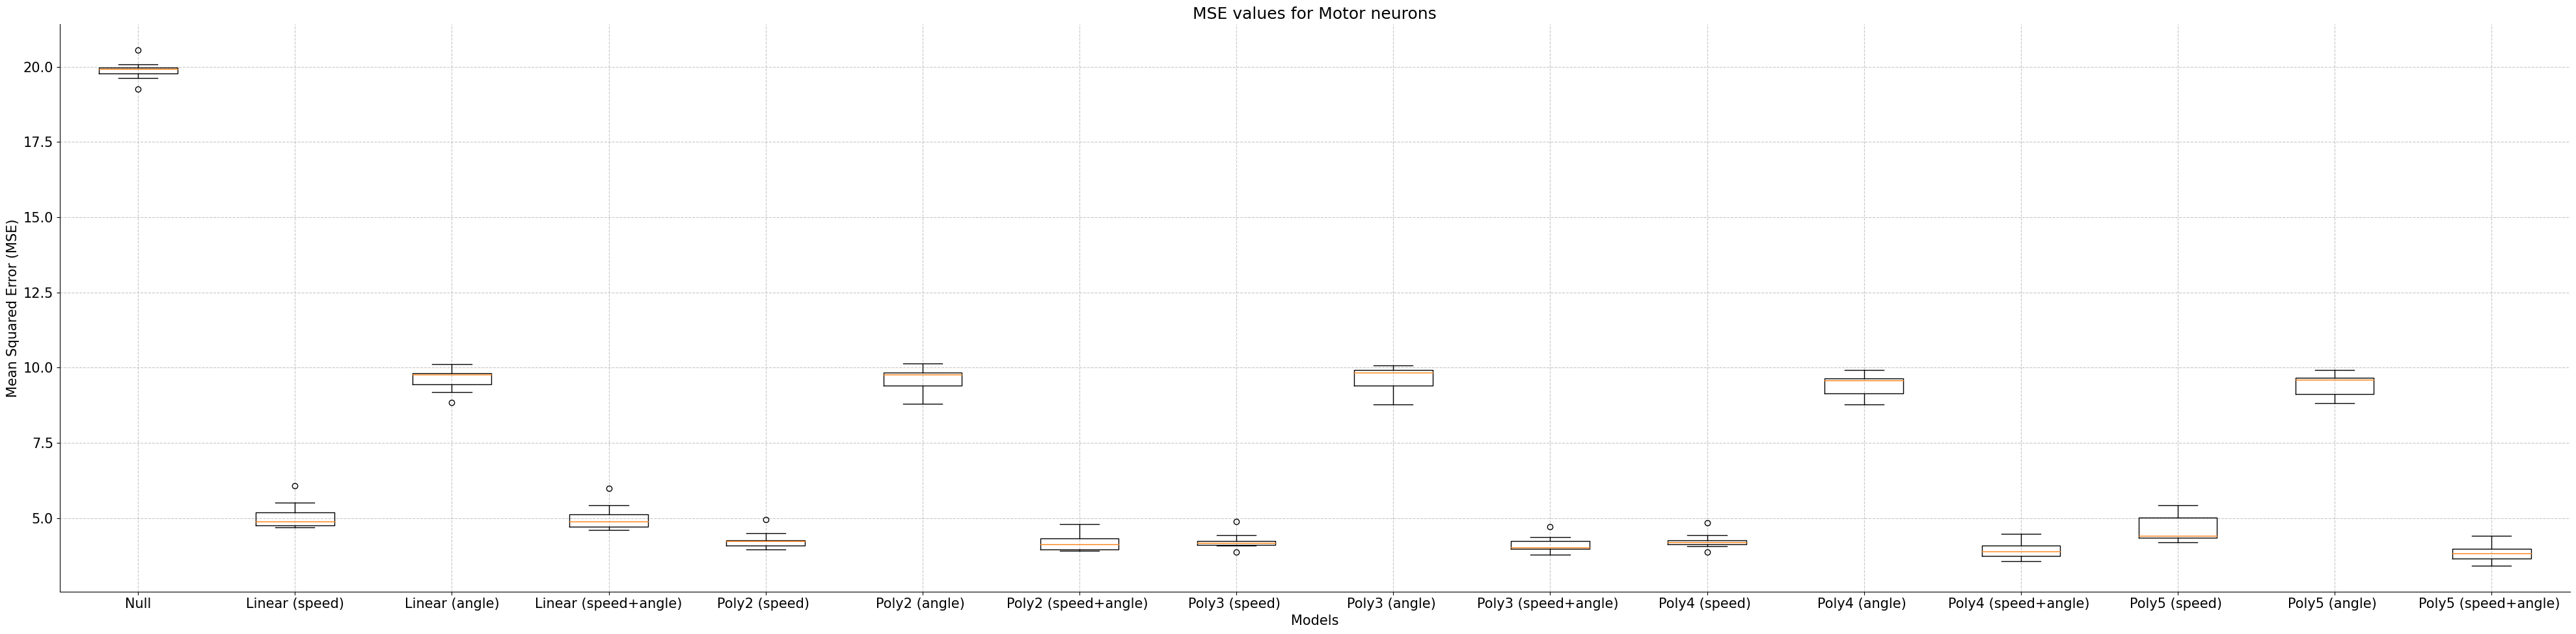

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_motor_pc, mse_motor_lineal_run, mse_motor_lineal_multinput, mse_motor_poli2_run, mse_motor_poli2_multinput, mse_motor_poli3_run, mse_motor_poli3_multinput, mse_motor_poli4_run, mse_motor_poli4_multinput, mse_motor_poli5_run, mse_motor_poli5_multinput]
all_mse_values = [mse_null_X_motor_pc, mse_motor_lineal_run,mse_motor_lineal_angle, mse_motor_lineal_multinput, mse_motor_poli2_run,mse_motor_poli2_angle, mse_motor_poli2_multinput, mse_motor_poli3_run,mse_motor_poli3_angle, mse_motor_poli3_multinput, mse_motor_poli4_run,mse_motor_poli4_angle, mse_motor_poli4_multinput, mse_motor_poli5_run,mse_motor_poli5_angle, mse_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Motor neurons')

# Display the plot
plt.show()

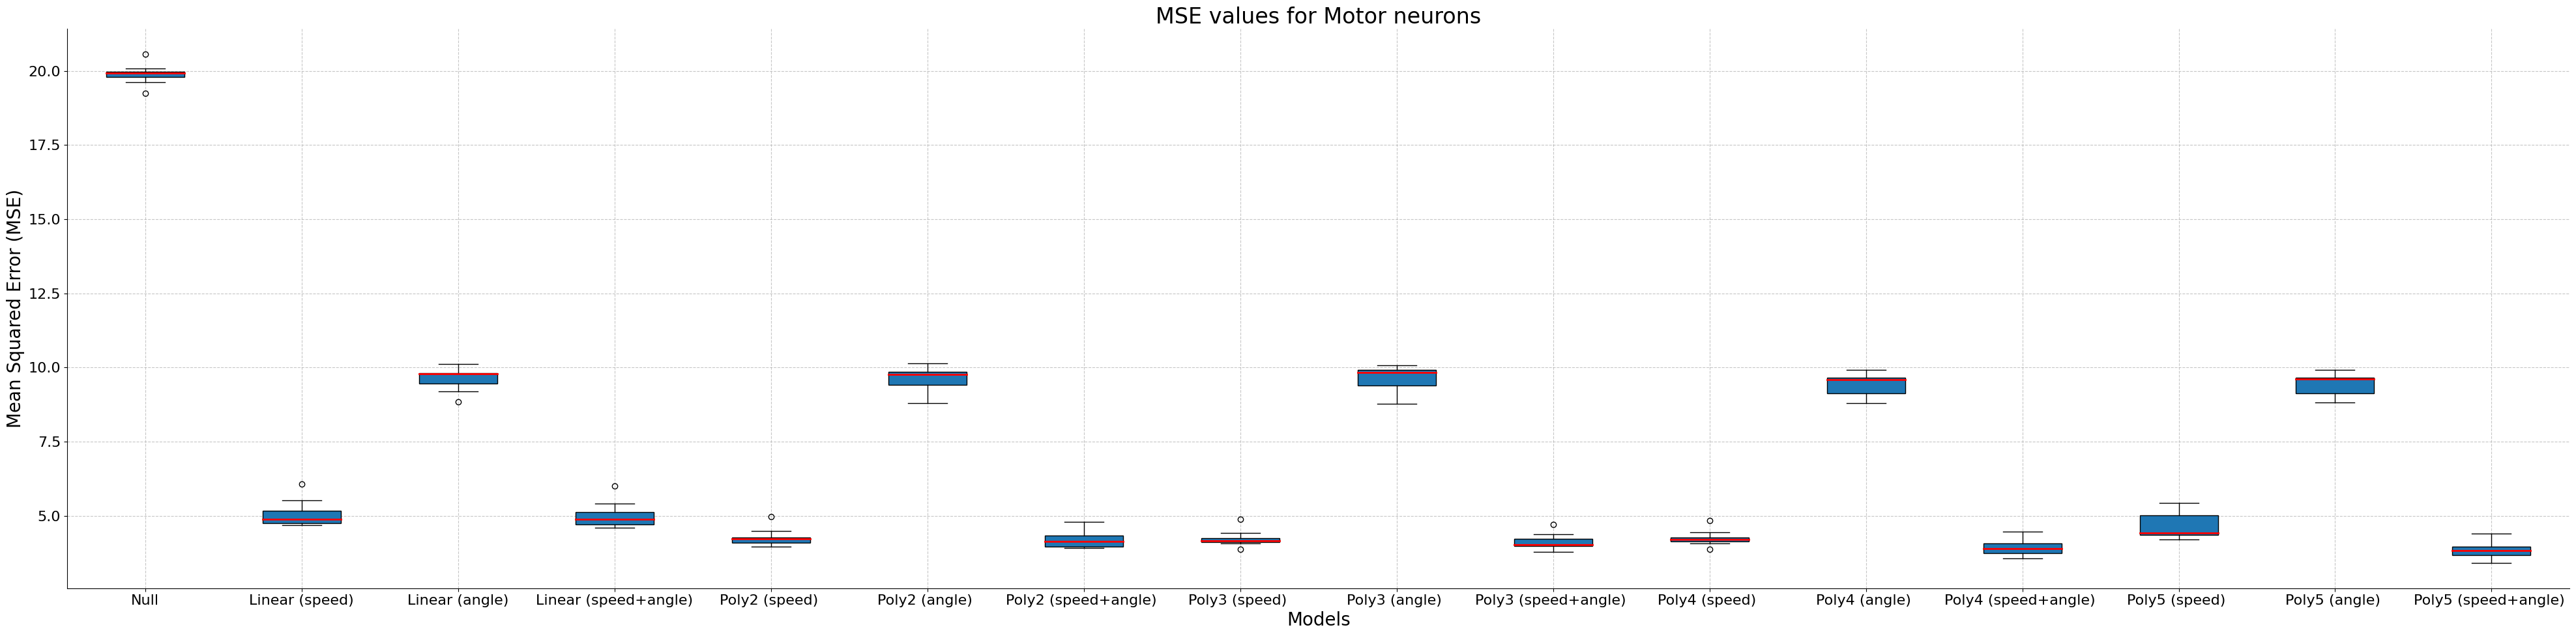

In [ ]:

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_motor_pc, mse_motor_lineal_run, mse_motor_lineal_angle, mse_motor_lineal_multinput,
                  mse_motor_poli2_run, mse_motor_poli2_angle, mse_motor_poli2_multinput,
                  mse_motor_poli3_run, mse_motor_poli3_angle, mse_motor_poli3_multinput,
                  mse_motor_poli4_run, mse_motor_poli4_angle, mse_motor_poli4_multinput,
                  mse_motor_poli5_run, mse_motor_poli5_angle, mse_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)',
                                    'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                    'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                    'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                    'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '], patch_artist=True,medianprops=dict(color='red', linewidth=2))


# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Motor neurons', fontsize=24)

# Display the plot
plt.show()


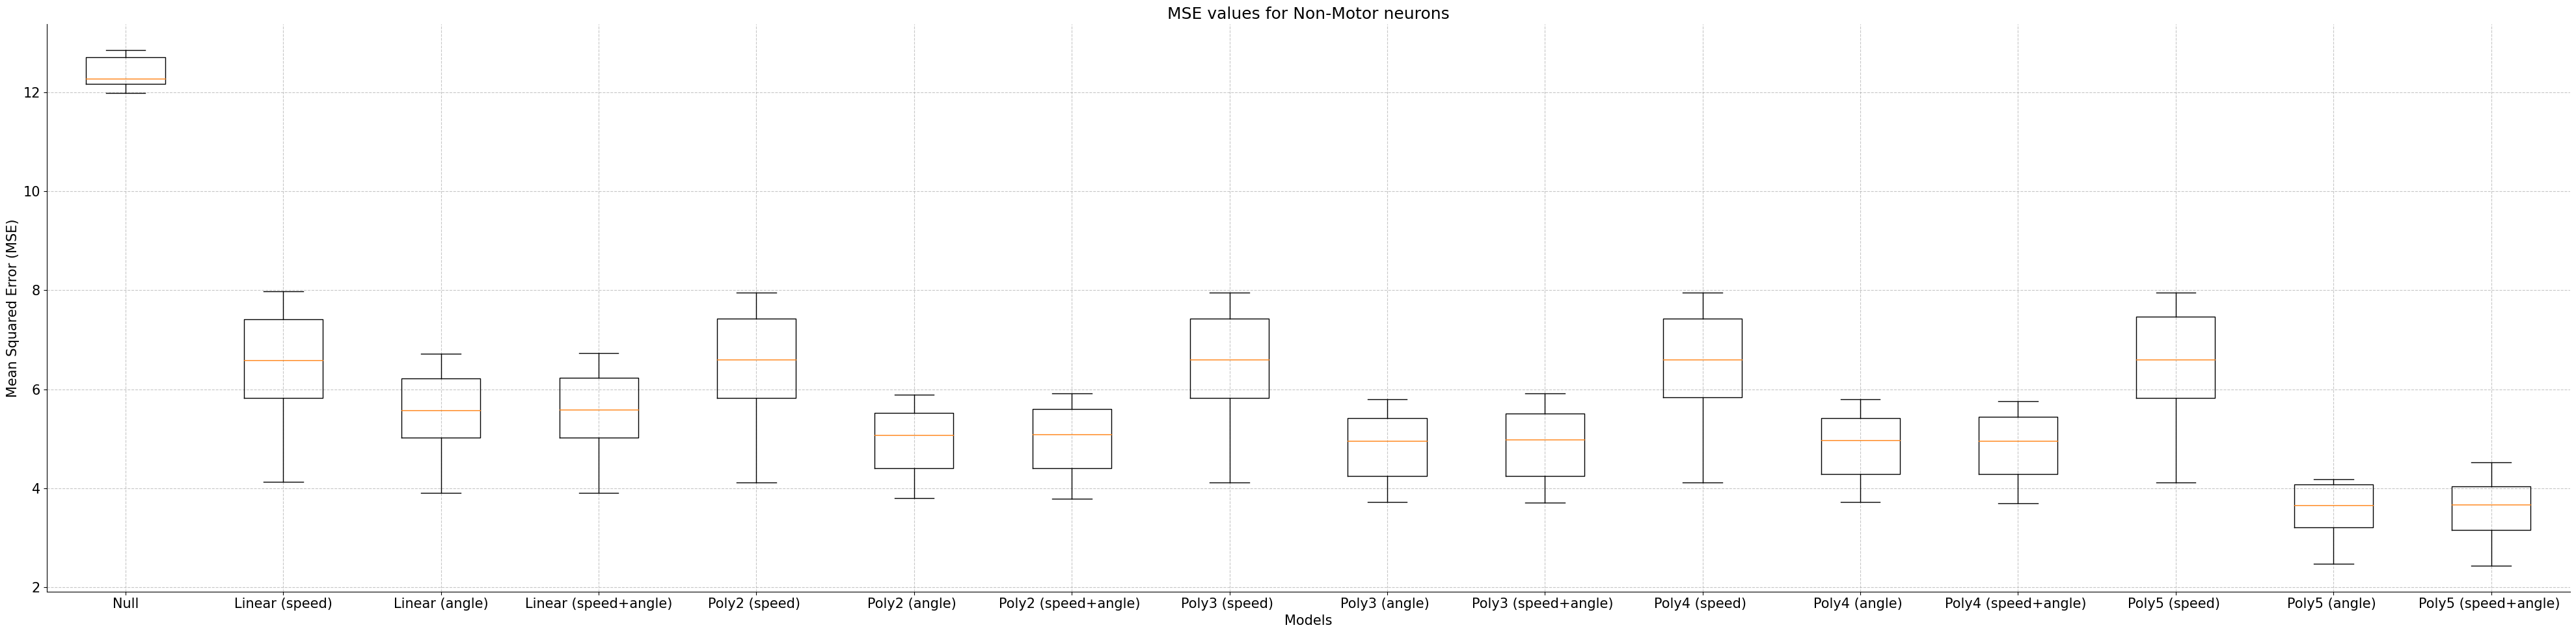

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_non_motor_pc, mse_non_motor_lineal_angle, mse_non_motor_lineal_multinput, mse_non_motor_poli2_angle, mse_non_motor_poli2_multinput, mse_non_motor_poli3_angle, mse_non_motor_poli3_multinput, mse_non_motor_poli4_angle, mse_non_motor_poli4_multinput, mse_non_motor_poli5_angle, mse_non_motor_poli5_multinput]
all_mse_values = [mse_null_X_non_motor_pc, mse_non_motor_lineal_run,mse_non_motor_lineal_angle, mse_non_motor_lineal_multinput, mse_non_motor_poli2_run,mse_non_motor_poli2_angle, mse_non_motor_poli2_multinput, mse_non_motor_poli3_run,mse_non_motor_poli3_angle, mse_non_motor_poli3_multinput, mse_non_motor_poli4_run,mse_non_motor_poli4_angle, mse_non_motor_poli4_multinput, mse_non_motor_poli5_run,mse_non_motor_poli5_angle, mse_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (angle) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Non-Motor neurons')

# Display the plot
plt.show()

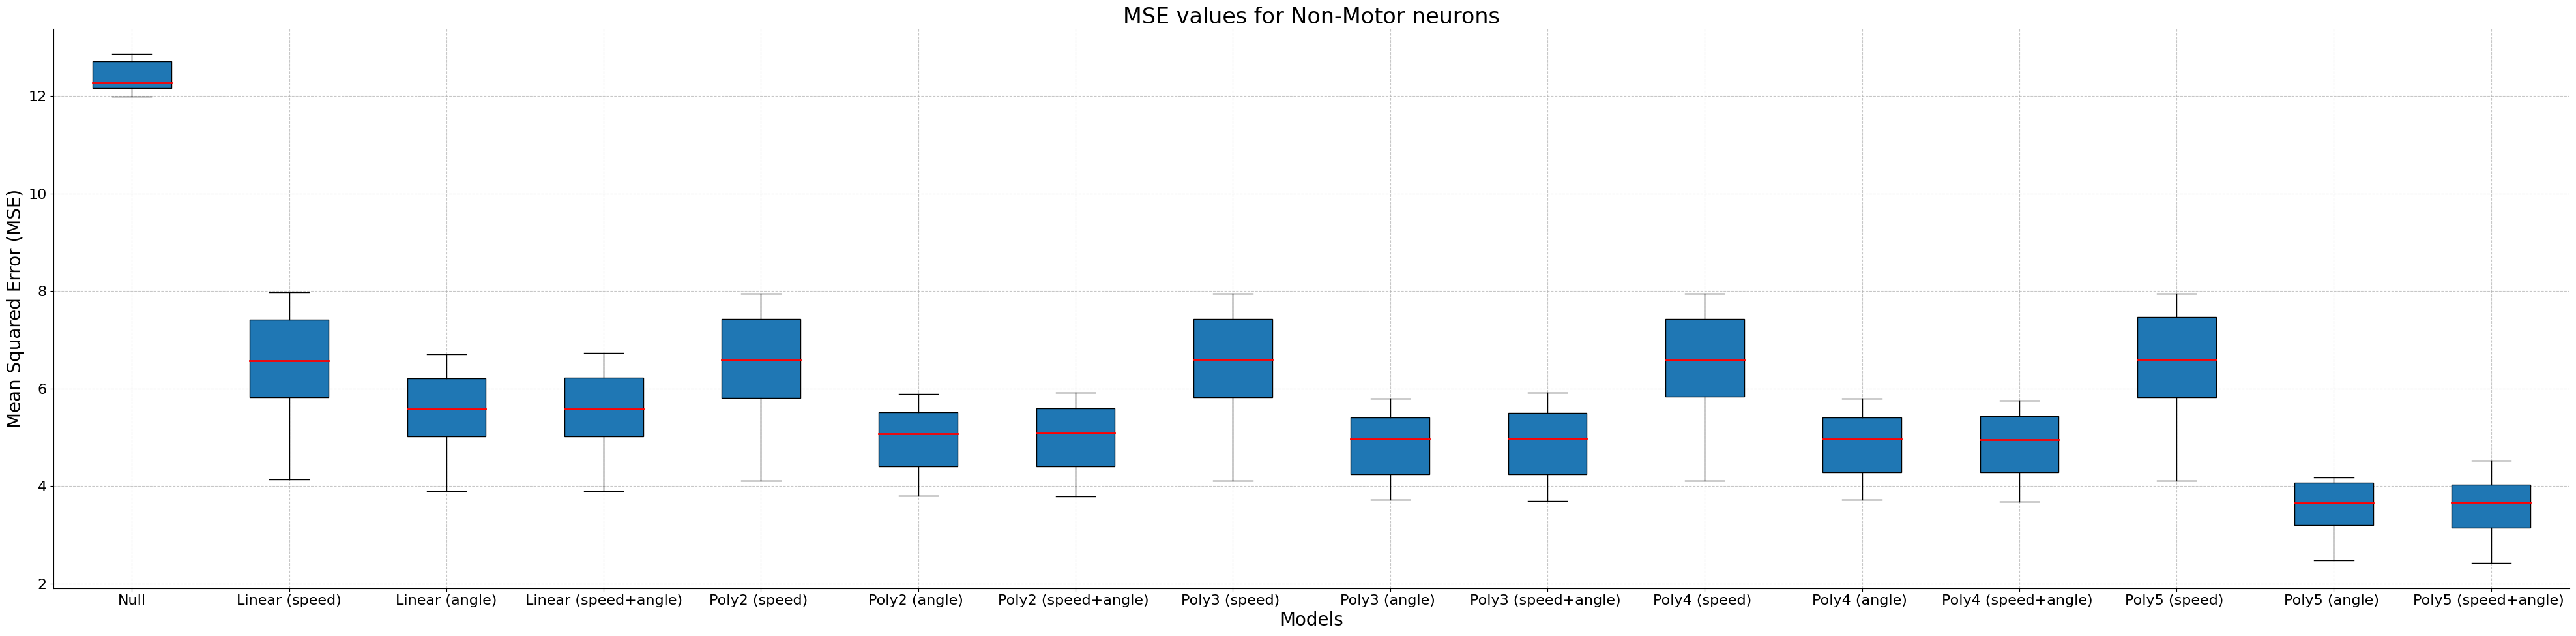

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_non_motor_pc, mse_non_motor_lineal_run, mse_non_motor_lineal_angle, mse_non_motor_lineal_multinput,
                  mse_non_motor_poli2_run, mse_non_motor_poli2_angle, mse_non_motor_poli2_multinput,
                  mse_non_motor_poli3_run, mse_non_motor_poli3_angle, mse_non_motor_poli3_multinput,
                  mse_non_motor_poli4_run, mse_non_motor_poli4_angle, mse_non_motor_poli4_multinput,
                  mse_non_motor_poli5_run, mse_non_motor_poli5_angle, mse_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)',
                                               'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                               'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                               'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                               'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Non-Motor neurons', fontsize=24)

# Display the plot
plt.show()


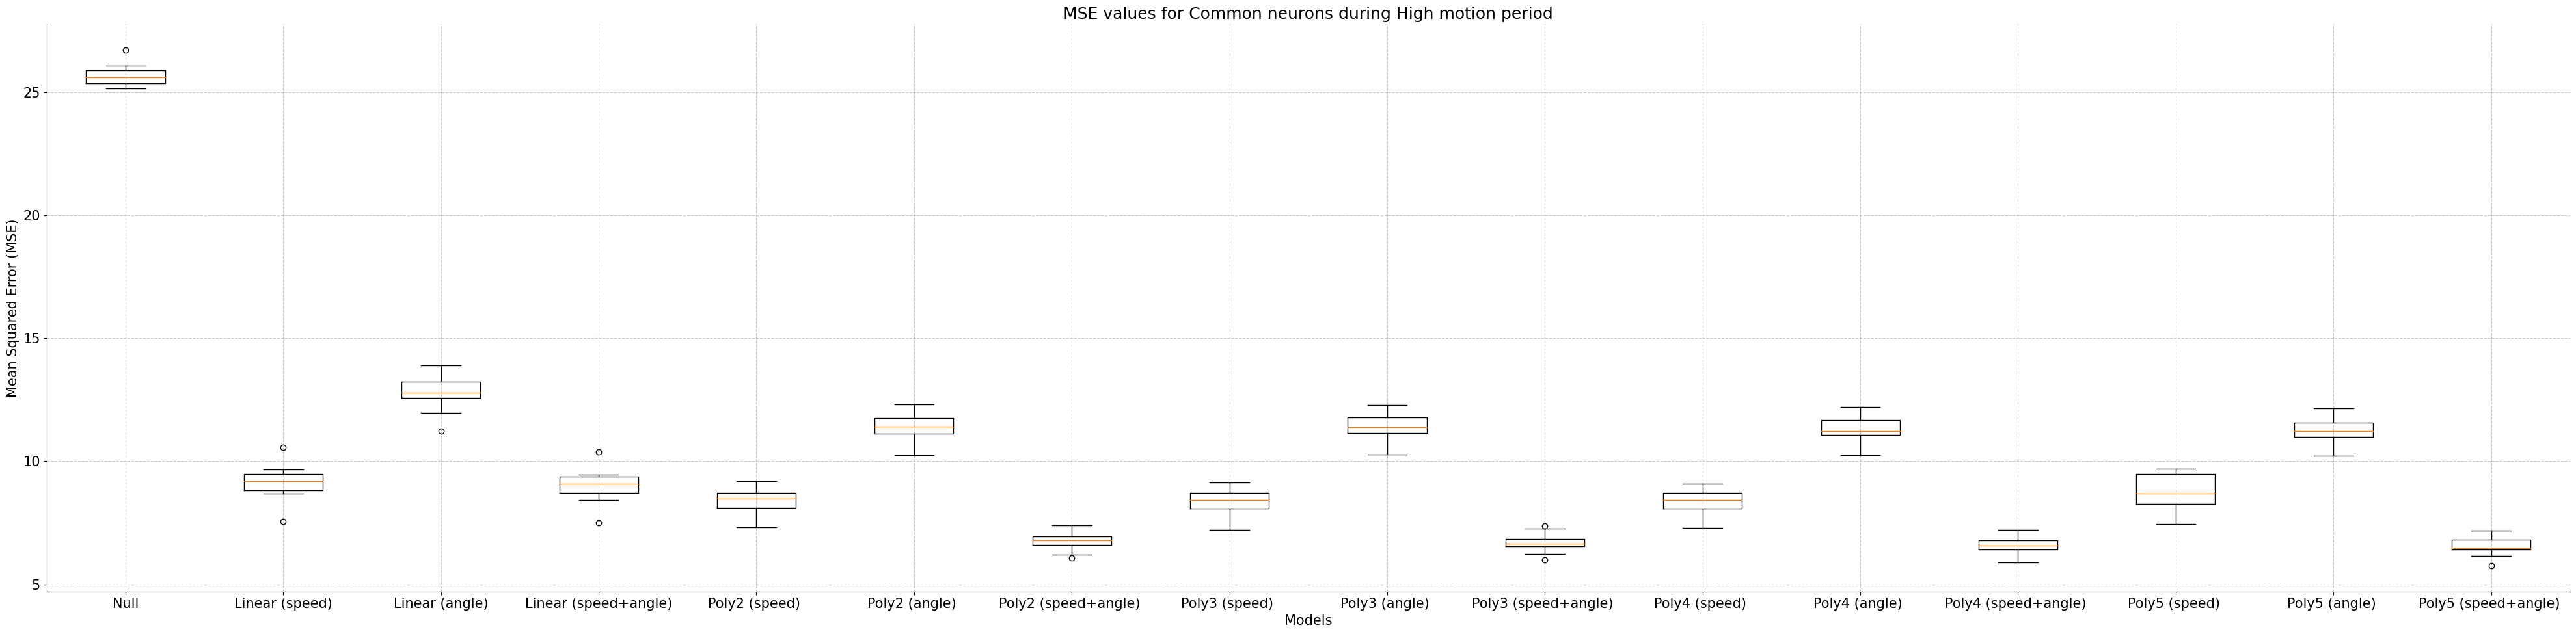

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_common_motor_pc,mse_common_motor_lineal_run, mse_common_motor_lineal_multinput, mse_common_motor_poli2_run, mse_common_motor_poli2_multinput, mse_common_motor_poli3_run, mse_common_motor_poli3_multinput, mse_common_motor_poli4_run, mse_common_motor_poli4_multinput, mse_common_motor_poli5_run, mse_common_motor_poli5_multinput]
all_mse_values = [mse_null_X_common_motor_pc,mse_common_motor_lineal_run,mse_common_motor_lineal_angle, mse_common_motor_lineal_multinput, mse_common_motor_poli2_run,mse_common_motor_poli2_angle, mse_common_motor_poli2_multinput, mse_common_motor_poli3_run,mse_common_motor_poli3_angle, mse_common_motor_poli3_multinput, mse_common_motor_poli4_run,mse_common_motor_poli4_angle, mse_common_motor_poli4_multinput, mse_common_motor_poli5_run,mse_common_motor_poli5_angle, mse_common_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Common neurons during High motion period')

# Display the plot
plt.show()

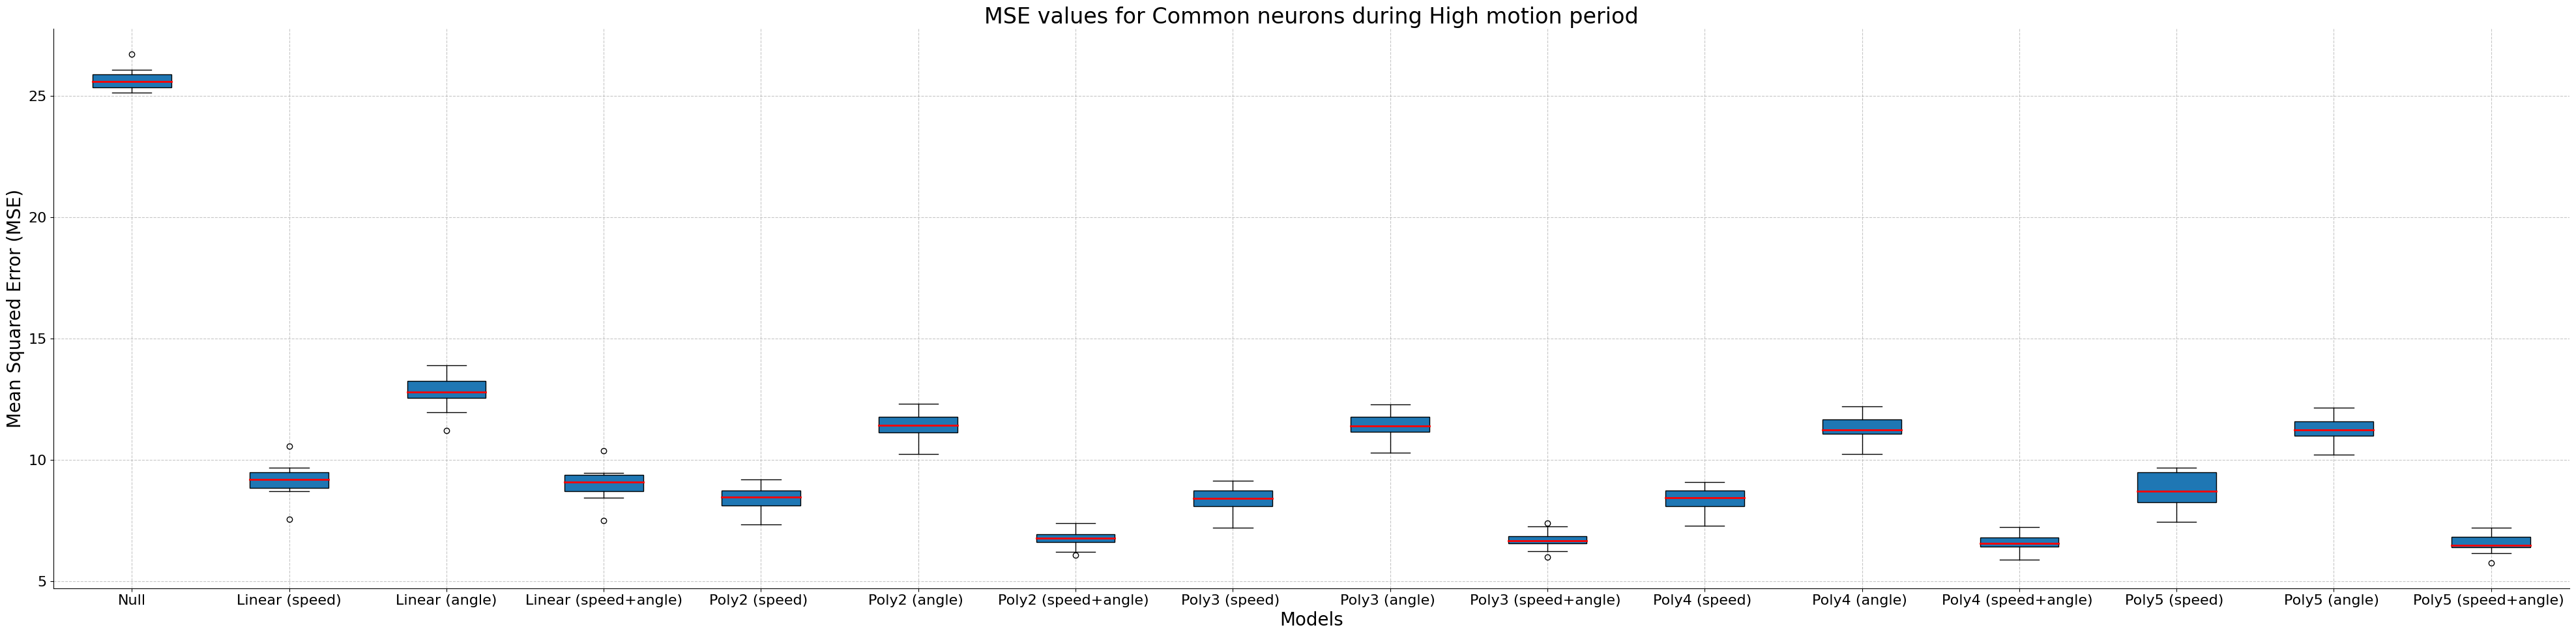

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_common_motor_pc, mse_common_motor_lineal_run, mse_common_motor_lineal_angle, mse_common_motor_lineal_multinput,
                  mse_common_motor_poli2_run, mse_common_motor_poli2_angle, mse_common_motor_poli2_multinput,
                  mse_common_motor_poli3_run, mse_common_motor_poli3_angle, mse_common_motor_poli3_multinput,
                  mse_common_motor_poli4_run, mse_common_motor_poli4_angle, mse_common_motor_poli4_multinput,
                  mse_common_motor_poli5_run, mse_common_motor_poli5_angle, mse_common_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (angle)', 'Linear (speed+angle)',
                                               'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                               'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                               'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                               'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Common neurons during High motion period', fontsize=24)

# Display the plot
plt.show()


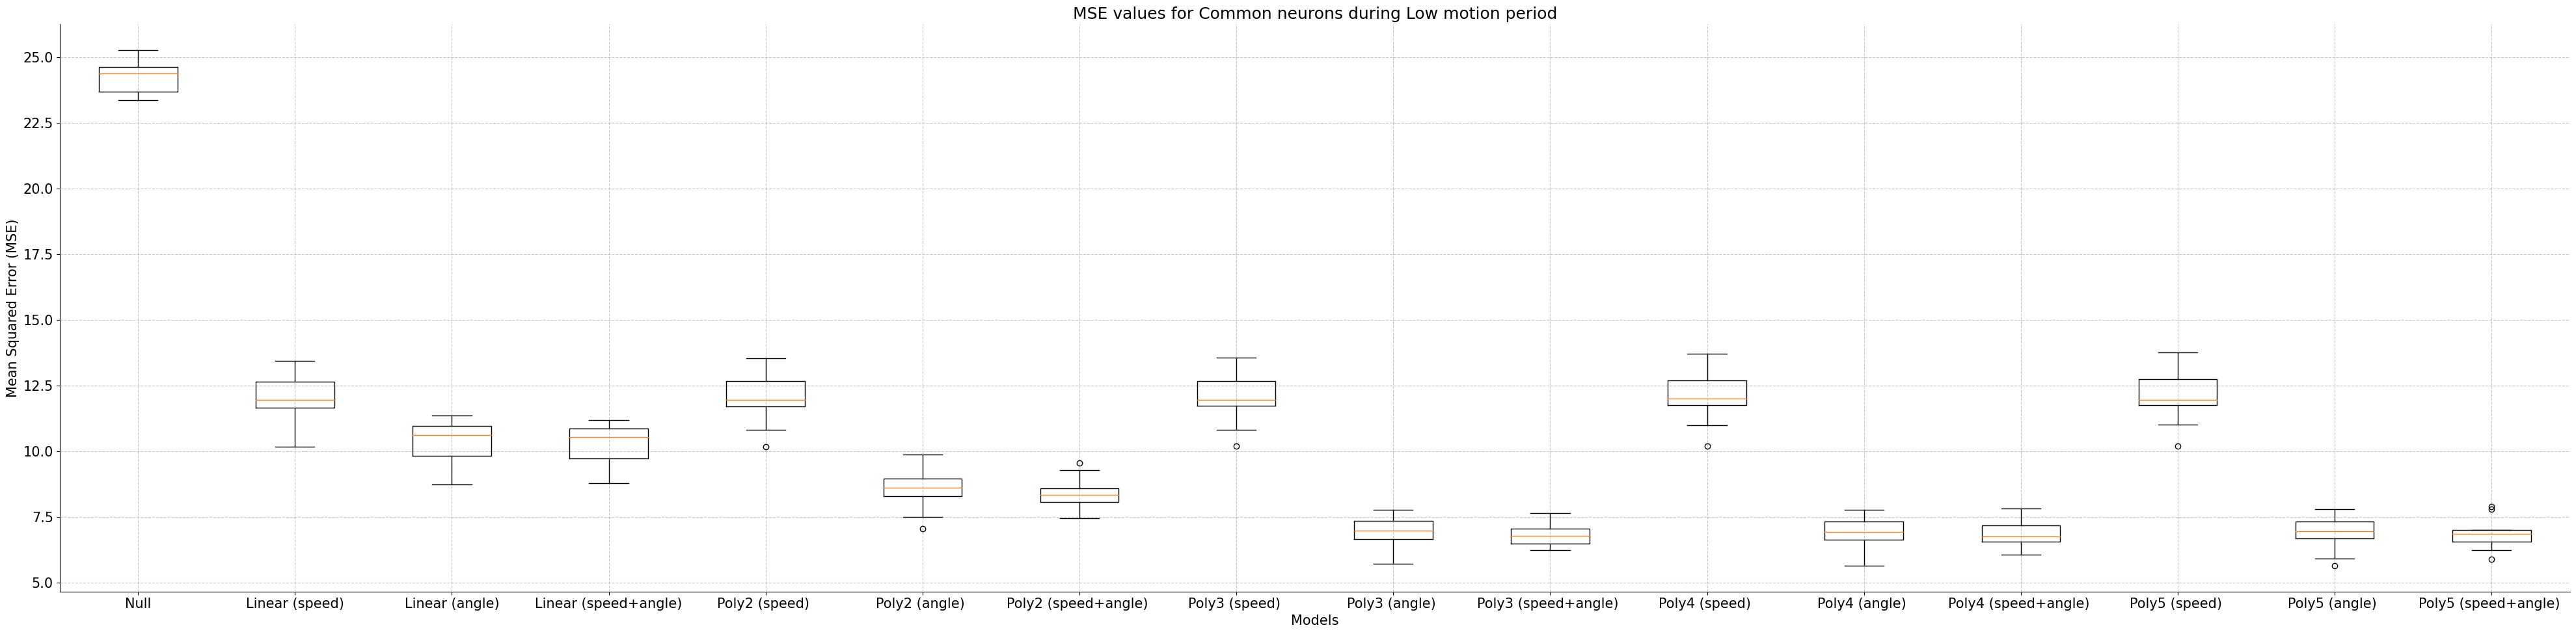

In [ ]:
# Combine the MSE values into a list of lists
#all_mse_values = [mse_null_X_common_non_motor_pc,mse_common_non_motor_lineal_angle, mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_angle, mse_common_non_motor_poli2_multinput, mse_common_non_motor_poli3_angle, mse_common_non_motor_poli3_multinput, mse_common_non_motor_poli4_angle, mse_common_non_motor_poli4_multinput, mse_common_non_motor_poli5_angle, mse_common_non_motor_poli5_multinput]
all_mse_values = [mse_null_X_common_non_motor_pc,mse_common_non_motor_lineal_run,mse_common_non_motor_lineal_angle, mse_common_non_motor_lineal_multinput, mse_common_non_motor_poli2_run,mse_common_non_motor_poli2_angle, mse_common_non_motor_poli2_multinput, mse_common_non_motor_poli3_run,mse_common_non_motor_poli3_angle, mse_common_non_motor_poli3_multinput, mse_common_non_motor_poli4_run,mse_common_non_motor_poli4_angle, mse_common_non_motor_poli4_multinput, mse_common_non_motor_poli5_run,mse_common_non_motor_poli5_angle, mse_common_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
#plt.boxplot(all_mse_values, labels=['Null','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (angle) ','Poly5 (speed+angle) '])
plt.boxplot(all_mse_values, labels=['Null','Linear (speed)','Linear (angle)', 'Linear (speed+angle)', 'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ', 'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ', 'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ', 'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '])

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values for Common neurons during Low motion period')

# Display the plot
plt.show()

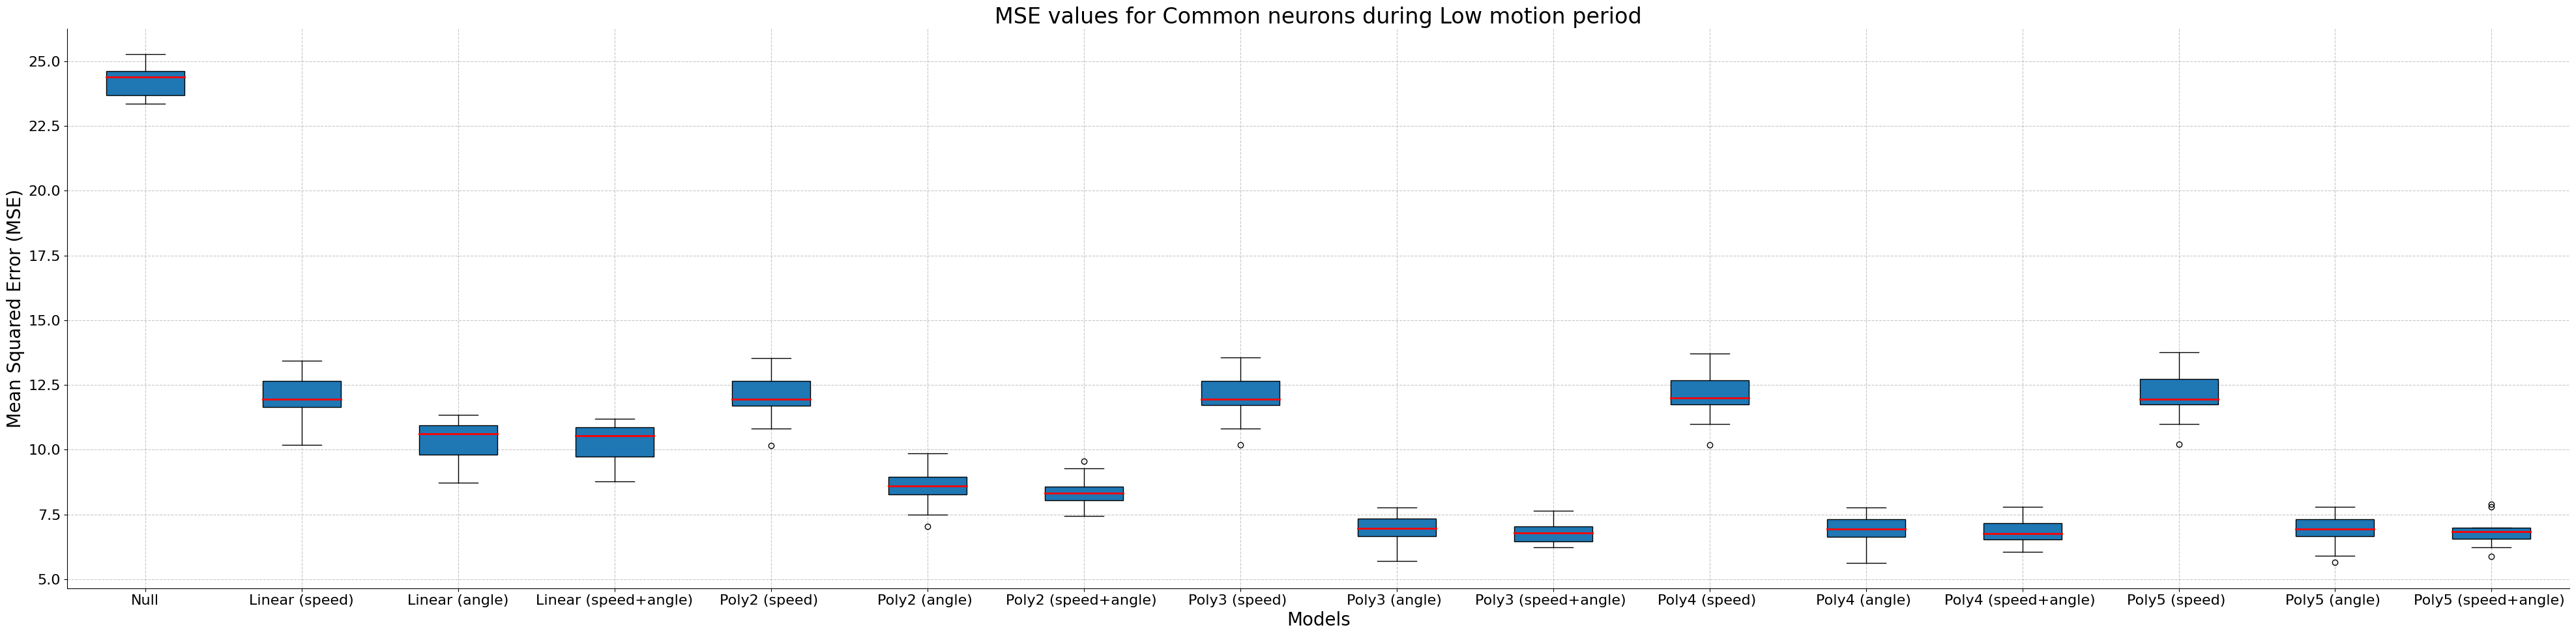

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_null_X_common_non_motor_pc, mse_common_non_motor_lineal_run, mse_common_non_motor_lineal_angle, mse_common_non_motor_lineal_multinput,
                  mse_common_non_motor_poli2_run, mse_common_non_motor_poli2_angle, mse_common_non_motor_poli2_multinput,
                  mse_common_non_motor_poli3_run, mse_common_non_motor_poli3_angle, mse_common_non_motor_poli3_multinput,
                  mse_common_non_motor_poli4_run, mse_common_non_motor_poli4_angle, mse_common_non_motor_poli4_multinput,
                  mse_common_non_motor_poli5_run, mse_common_non_motor_poli5_angle, mse_common_non_motor_poli5_multinput]

fig, ax = plt.subplots(figsize=(40, 10))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Null','Linear (speed)', 'Linear (angle)', 'Linear (speed+angle)',
                                               'Poly2 (speed) ','Poly2 (angle) ','Poly2 (speed+angle) ',
                                               'Poly3 (speed) ','Poly3 (angle) ','Poly3 (speed+angle) ',
                                               'Poly4 (speed) ','Poly4 (angle) ','Poly4 (speed+angle) ',
                                               'Poly5 (speed) ','Poly5 (angle) ','Poly5 (speed+angle) '],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Models', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values for Common neurons during Low motion period', fontsize=24)

# Display the plot
plt.show()


Motor neurons
The best model is: Poly 5 Multi with MSE: 3.826427193909042

Non-motor neurons during low motion period
The best model is: Poly 5 Angle with MSE: 3.658769329871377

Common neurons during high motion period
The best model is: Poly 5 Multi with MSE: 6.464288806153952

Common neurons during low motion period
The best model is: Poly 4 Multi with MSE: 6.7487700798680414




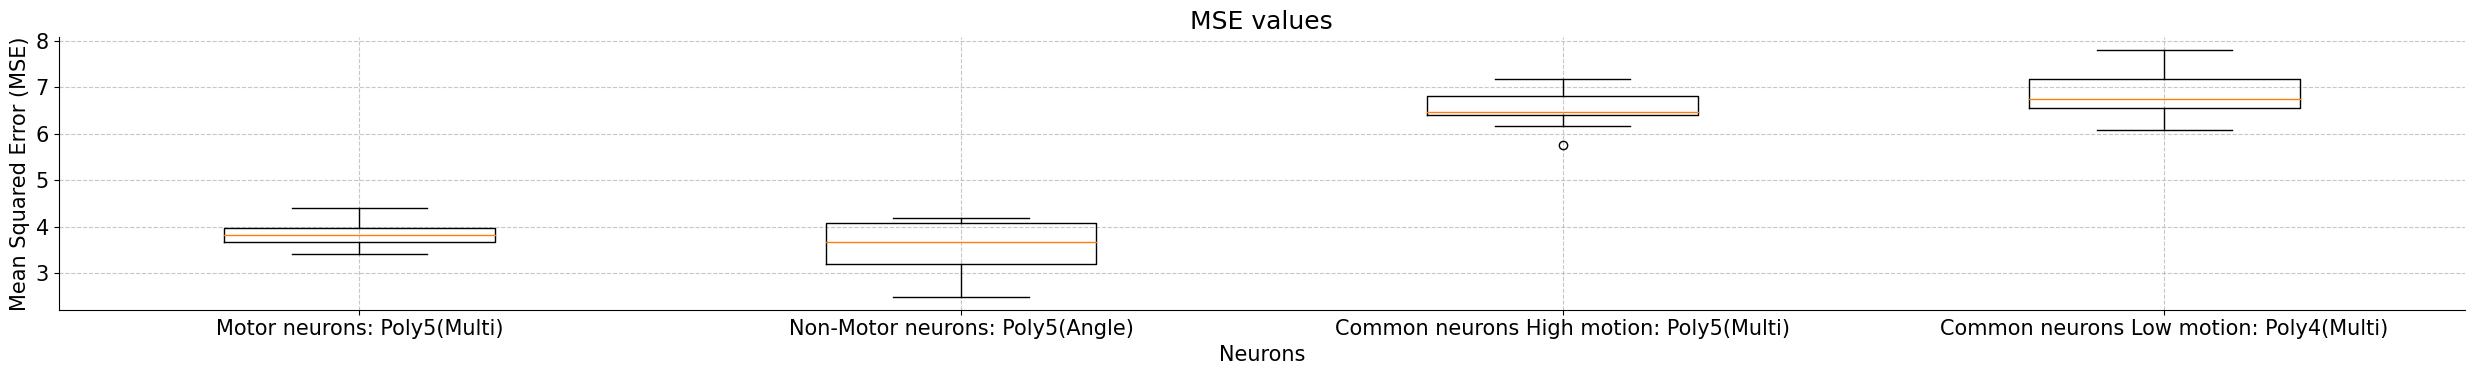

In [ ]:
all_mse_values=[ mse_motor_poli5_multinput, mse_non_motor_poli5_angle, mse_common_motor_poli5_multinput ,mse_common_non_motor_poli4_multinput]
fig, ax = plt.subplots(figsize=(25, 4))
# Create a boxplot for all models
plt.boxplot(all_mse_values, labels=['Motor neurons: Poly5(Multi)', 'Non-Motor neurons: Poly5(Angle)', 'Common neurons High motion: Poly5(Multi)','Common neurons Low motion: Poly4(Multi)'])
ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Neurons')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values')

# Display the plot
plt.show()

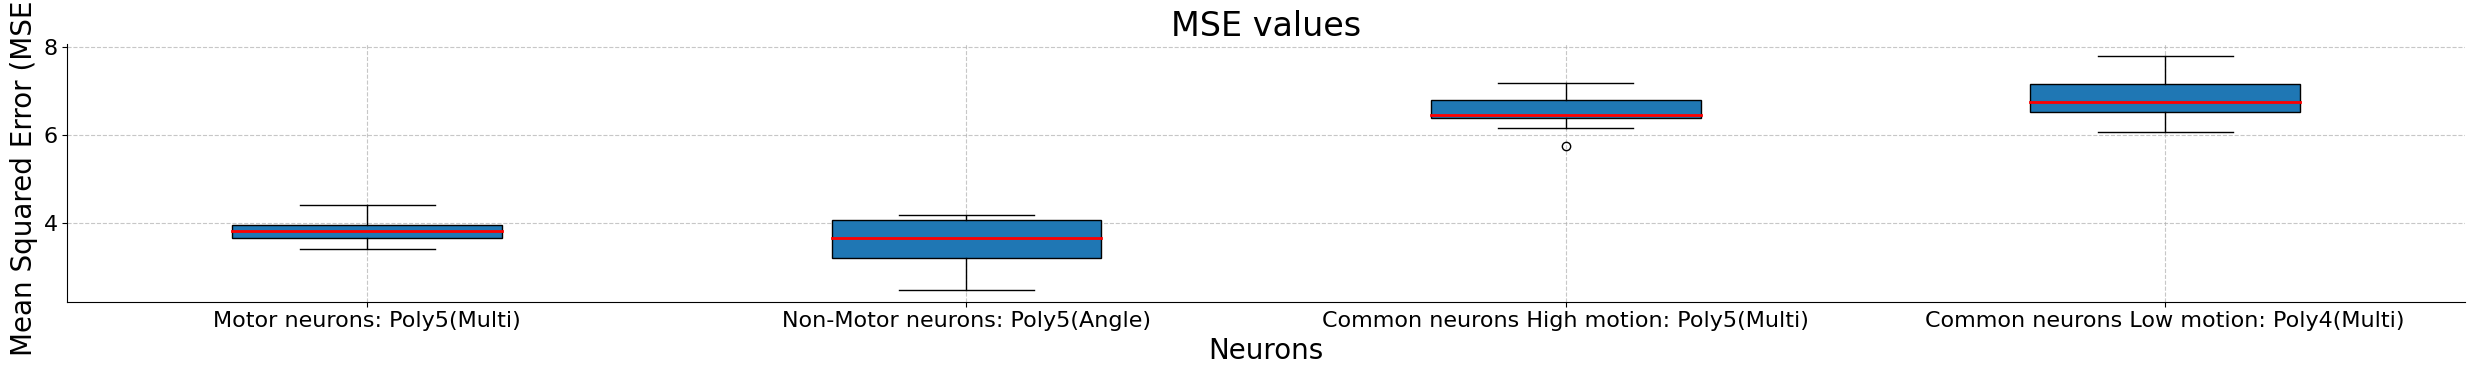

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values = [mse_motor_poli5_multinput, mse_non_motor_poli5_angle, mse_common_motor_poli5_multinput, mse_common_non_motor_poli4_multinput]

fig, ax = plt.subplots(figsize=(25, 4))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Motor neurons: Poly5(Multi)', 'Non-Motor neurons: Poly5(Angle)', 'Common neurons High motion: Poly5(Multi)','Common neurons Low motion: Poly4(Multi)'],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Neurons', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values', fontsize=24)

# Display the plot
plt.show()


In [ ]:
# @title Null distributions
mse_null_X_motor_pc=get_null(X_motor_pc)
mse_null_X_common_motor_pc=get_null(X_common_motor_pc)
mse_null_X_common_non_motor_pc=get_null(X_common_non_motor_pc)
mse_null_X_non_motor_pc=get_null(X_non_motor_pc)

print('Null error Motor neurons:',np.median(mse_null_X_motor_pc))
print('Null error Common neurons during High motion:',np.median(mse_null_X_common_motor_pc))
print('Null error Common neurons during Low motion:',np.median(mse_null_X_common_non_motor_pc))
print('Null error Non-Motor neurons:',np.median(mse_null_X_non_motor_pc))

Null error Motor neurons: 19.935404375937132
Null error Common neurons during High motion: 25.5997064478437
Null error Common neurons during Low motion: 24.38338074309963
Null error Non-Motor neurons: 12.279180933285044


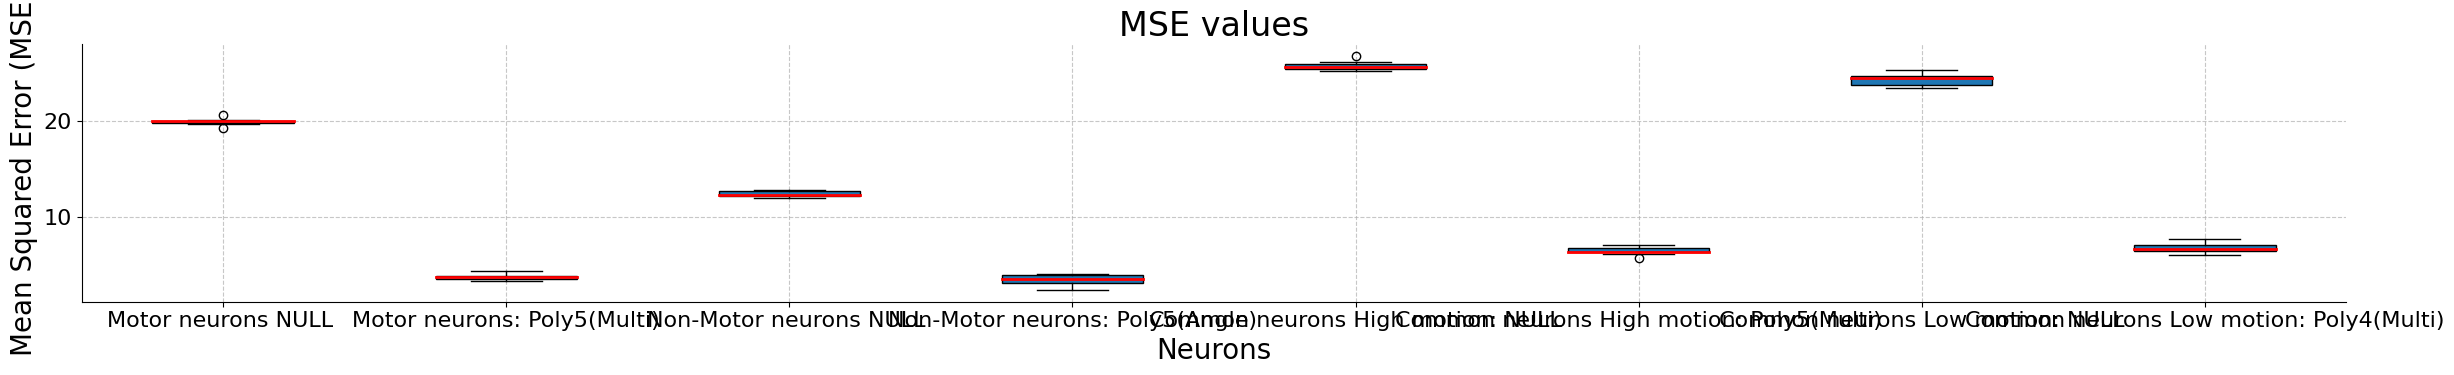

In [ ]:
import matplotlib.pyplot as plt

# Combine the MSE values into a list of lists
all_mse_values =  [mse_null_X_motor_pc, mse_motor_poli5_multinput, mse_null_X_non_motor_pc , mse_non_motor_poli5_angle,  mse_null_X_common_motor_pc, mse_common_motor_poli5_multinput, mse_null_X_common_non_motor_pc,mse_common_non_motor_poli4_multinput]

fig, ax = plt.subplots(figsize=(25, 4))
# Create a boxplot for all models
boxplot = plt.boxplot(all_mse_values, labels=['Motor neurons NULL ','Motor neurons: Poly5(Multi)', 'Non-Motor neurons NULL ','Non-Motor neurons: Poly5(Angle)', 'Common neurons High motion: NULL', 'Common neurons High motion: Poly5(Multi)','Common neurons Low motion: NULL','Common neurons Low motion: Poly4(Multi)'],
                      patch_artist=True, medianprops=dict(color='red', linewidth=2))

# Increase font size
ax.tick_params(axis='both', labelsize=16)

# Make lines from plot ticker darker
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')

ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Neurons', fontsize=20)
plt.ylabel('Mean Squared Error (MSE)', fontsize=20)
plt.title('MSE values', fontsize=24)

# Display the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


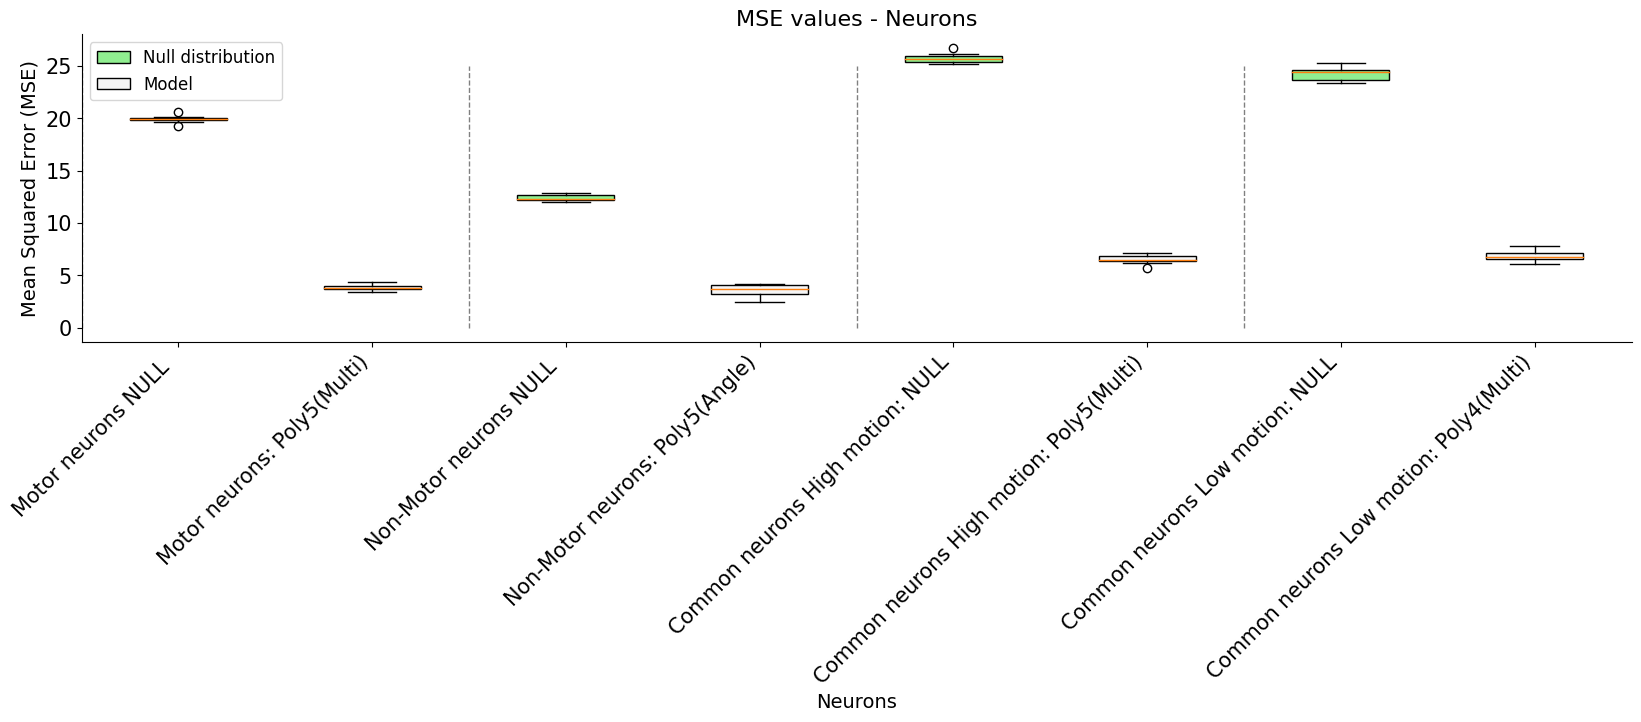

In [ ]:
# Set background color for 'Stimulation' and 'Spontaneous' conditions
all_mse_values =  [mse_null_X_motor_pc, mse_motor_poli5_multinput, mse_null_X_non_motor_pc , mse_non_motor_poli5_angle,  mse_null_X_common_motor_pc, mse_common_motor_poli5_multinput, mse_null_X_common_non_motor_pc,mse_common_non_motor_poli4_multinput]
labels=['Motor neurons NULL ','Motor neurons: Poly5(Multi)', 'Non-Motor neurons NULL ','Non-Motor neurons: Poly5(Angle)', 'Common neurons High motion: NULL', 'Common neurons High motion: Poly5(Multi)','Common neurons Low motion: NULL','Common neurons Low motion: Poly4(Multi)']
background_colors = ['lightgreen' if i in [0, 2, 4, 6] else 'whitesmoke' for i in range(len(all_mse_values))]

# Create a single subplot
fig, ax = plt.subplots(figsize=(20, 4))

# Create boxplot with specified background colors
box = ax.boxplot(all_mse_values, labels=labels, patch_artist=True, boxprops=dict(facecolor='blue'))

# Customize box colors
#for patch, color in zip(box['boxes'], ['blue', 'orange', 'green', 'red']):
  #  patch.set_facecolor(color)

# Set background color for specific boxplots
for patch, color in zip(box['boxes'], background_colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_xlabel('Neurons', fontsize=14)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
# Rotate x-axis labels
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right')
# Set y-limit
#ax.set_ylim(20, 27)

# Create custom legend labels
legend_labels = ['Null distribution', 'Model']
ax.legend([box["boxes"][0], box["boxes"][1]], legend_labels, loc='upper left', fontsize=12)

# Set title
ax.set_title(f'MSE values - Neurons', fontsize=16)
# Add vertical lines between boxplots
for i in range(0, len(labels)-1,2):
    plt.vlines(x=i + 0.5, ymin=0, ymax=25, color='gray', linestyle='--', linewidth=1)

# Display the plot
plt.show()

In [ ]:
# @title Load spontaneous condition data
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

all_mse_values_spont=np.load('/content/drive/My Drive/Stringer/all_mse_values_spontaneous.npy')
all_mse_values_spont = all_mse_values_spont.tolist()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels_spont=['Motor neurons: Poly3(Multi)', 'Non-Motor neurons: Poly4(Multi)', 'Common neurons High motion: Poly3(Multi)','Common neurons Low motion: Poly4(Multi)']
labels_stim= ['Motor neurons: Poly5(Multi)', 'Non-Motor neurons: Poly5(Angle)', 'Common neurons High motion: Poly5(Multi)','Common neurons Low motion: Poly4(Multi)']

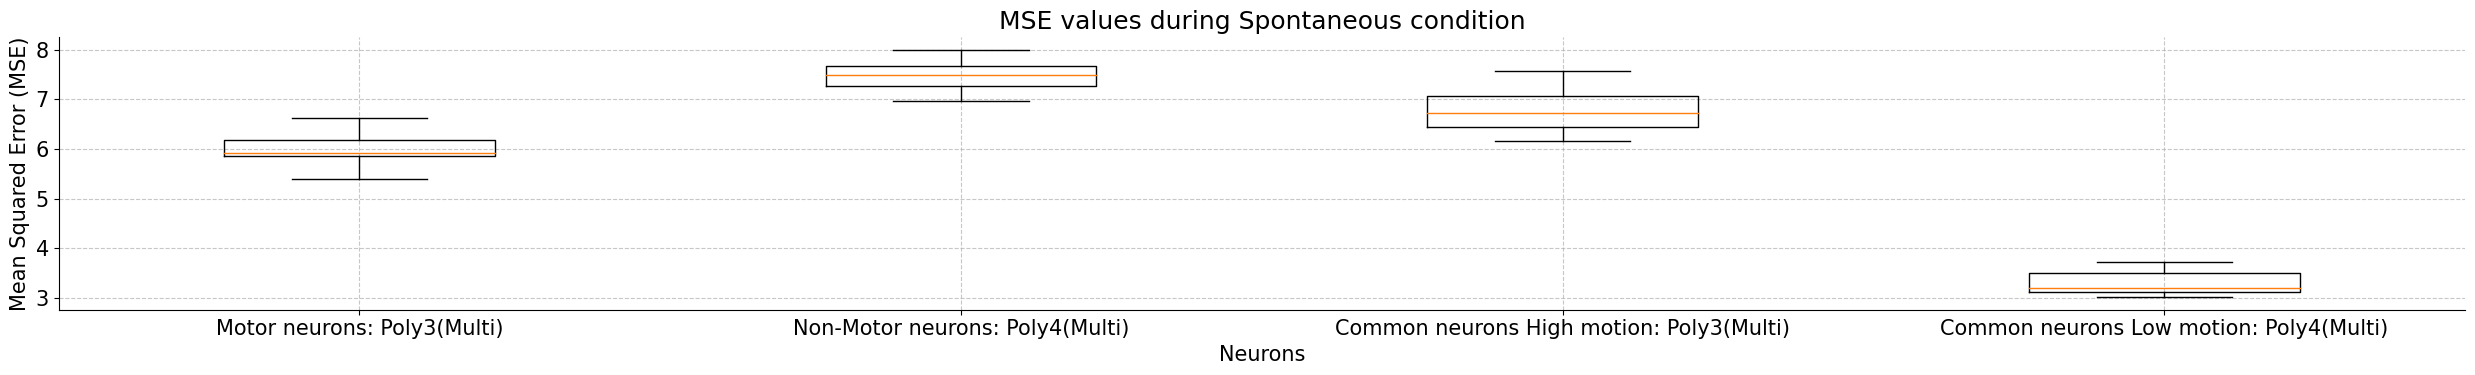

In [ ]:
fig, ax = plt.subplots(figsize=(25, 4))
# Create a boxplot for all models
plt.boxplot(all_mse_values_spont, labels=['Motor neurons: Poly3(Multi)', 'Non-Motor neurons: Poly4(Multi)', 'Common neurons High motion: Poly3(Multi)','Common neurons Low motion: Poly4(Multi)'])
ax.grid(True, linestyle='--', alpha=0.7)
# Add labels and title
plt.xlabel('Neurons')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE values during Spontaneous condition')

# Display the plot
plt.show()

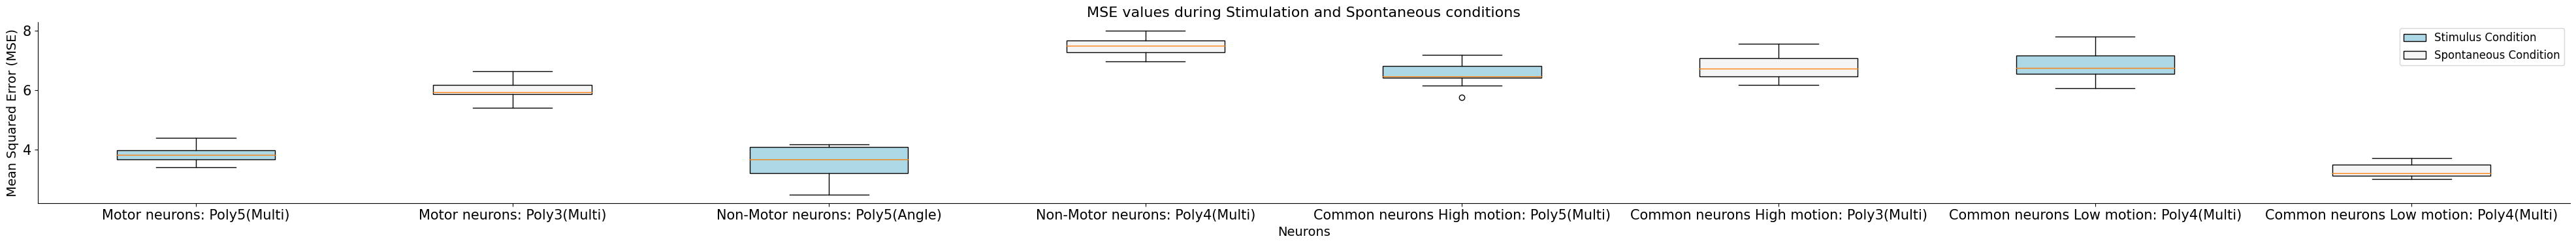

In [ ]:
all=[all_mse_values[0] ,all_mse_values_spont[0] ,all_mse_values[1], all_mse_values_spont[1], all_mse_values[2], all_mse_values_spont[2], all_mse_values[3] ,all_mse_values_spont[3]]
labels=[ labels_stim[0] , labels_spont[0] ,labels_stim[1] , labels_spont[1] , labels_stim[2] , labels_spont[2]  ,labels_stim[3]  ,labels_spont[3]   ]

fig, ax = plt.subplots(figsize=(40, 4))
# Create a boxplot for all models
# Set background color for 'Stimulation' and 'Spontaneous' conditions
# Set background color for specific boxplots
background_colors = ['lightblue' if i in [0, 2, 4, 6] else 'whitesmoke' for i in range(len(all))]

# Create boxplot with specified background colors
box = ax.boxplot(all, labels=labels, patch_artist=True, boxprops=dict(facecolor='blue'))

# Customize box colors
for patch, color in zip(box['boxes'], ['blue', 'orange', 'green', 'red']):
    patch.set_facecolor(color)

# Set background color for specific boxplots
for patch, color in zip(box['boxes'], background_colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_xlabel('Neurons', fontsize=14)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
ax.set_title('MSE values during Stimulation and Spontaneous conditions', fontsize=16)

# Create custom legend labels
legend_labels = ['Stimulus Condition', 'Spontaneous Condition']

# Create a legend with custom labels
ax.legend([box["boxes"][0], box["boxes"][1]], legend_labels, loc='upper right', fontsize=12)

# Display the plot
plt.show()

In [ ]:
print([labels_stim[2], labels_spont[2], labels_stim[3], labels_spont[3]])

['Common neurons High motion: Poly5(Multi)', 'Common neurons High motion: Poly3(Multi)', 'Common neurons Low motion: Poly4(Multi)', 'Common neurons Low motion: Poly4(Multi)']


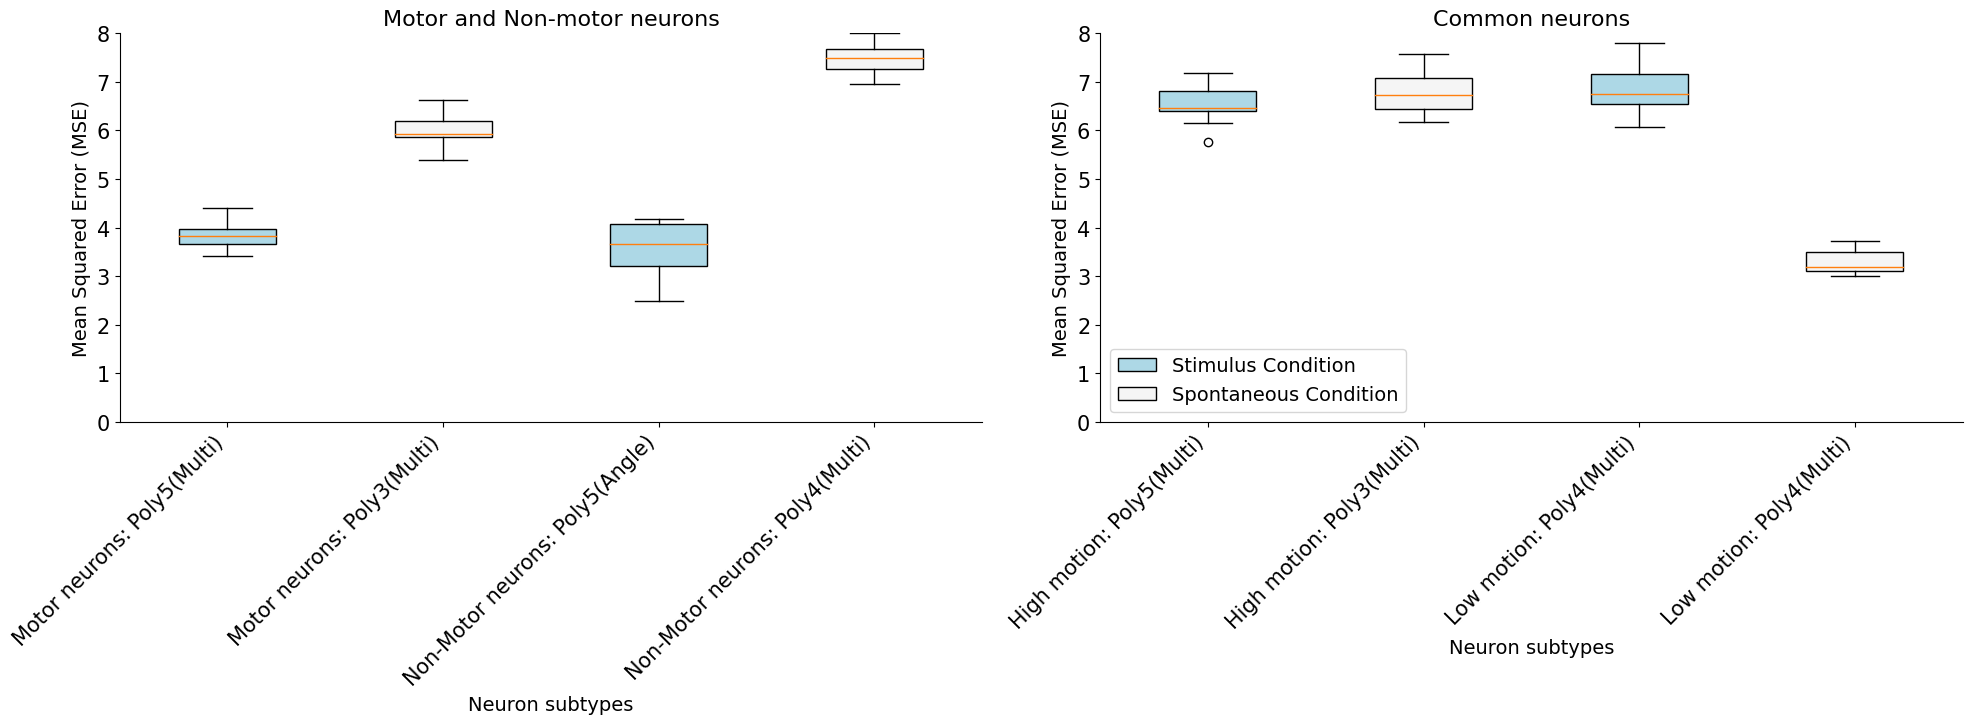

In [ ]:
import matplotlib.pyplot as plt

# Your data
all = [all_mse_values[0], all_mse_values_spont[0], all_mse_values[1], all_mse_values_spont[1],
       all_mse_values[2], all_mse_values_spont[2], all_mse_values[3], all_mse_values_spont[3]]

labels = [labels_stim[0], labels_spont[0], labels_stim[1], labels_spont[1], 'High motion: Poly5(Multi)', 'High motion: Poly3(Multi)', 'Low motion: Poly4(Multi)', 'Low motion: Poly4(Multi)']
          #labels_stim[2], labels_spont[2], labels_stim[3], labels_spont[3]]

# Set background color for 'Stimulation' and 'Spontaneous' conditions
background_colors = ['lightblue' if i in [0, 2, 4, 6] else 'whitesmoke' for i in range(len(all))]

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(20, 7.5))

# Loop over subplots
for i, ax in enumerate(axs):
    # Create boxplot with specified background colors
    start_idx = i * 4
    end_idx = start_idx + 4
    subset_all = all[start_idx:end_idx]
    subset_labels = labels[start_idx:end_idx]

    box = ax.boxplot(subset_all, labels=subset_labels, patch_artist=True, boxprops=dict(facecolor='blue'))

    # Customize box colors
    for patch, color in zip(box['boxes'], ['blue', 'orange', 'green', 'red']):
        patch.set_facecolor(color)

    # Set background color for specific boxplots
    for patch, color in zip(box['boxes'], background_colors[start_idx:end_idx]):
        patch.set_facecolor(color)

    # Add labels and title
    ax.set_xlabel('Neuron subtypes', fontsize=14)
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
        # Set x-axis labels with rotation
    ax.set_xticks(range(1, len(subset_labels) + 1))
    ax.set_xticklabels(subset_labels, rotation=45, ha='right')
    # Set y-limit
    ax.set_ylim(0, 8)

    # Create custom legend labels (using the last subplot to place the legend)
    if i == len(axs) - 1:
        legend_labels = ['Stimulus Condition', 'Spontaneous Condition']
        ax.legend([box["boxes"][0], box["boxes"][1]], legend_labels, loc='lower left', fontsize=14)
        ax.set_title(f'Common neurons', fontsize=16)
    else:
        legend_labels = ['Stimulus Condition', 'Spontaneous Condition']
        #ax.legend([box["boxes"][0], box["boxes"][1]], legend_labels, loc='upper left', fontsize=12)
        ax.set_title(f'Motor and Non-motor neurons', fontsize=16)
 # Rotate x-axis labels
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Display the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


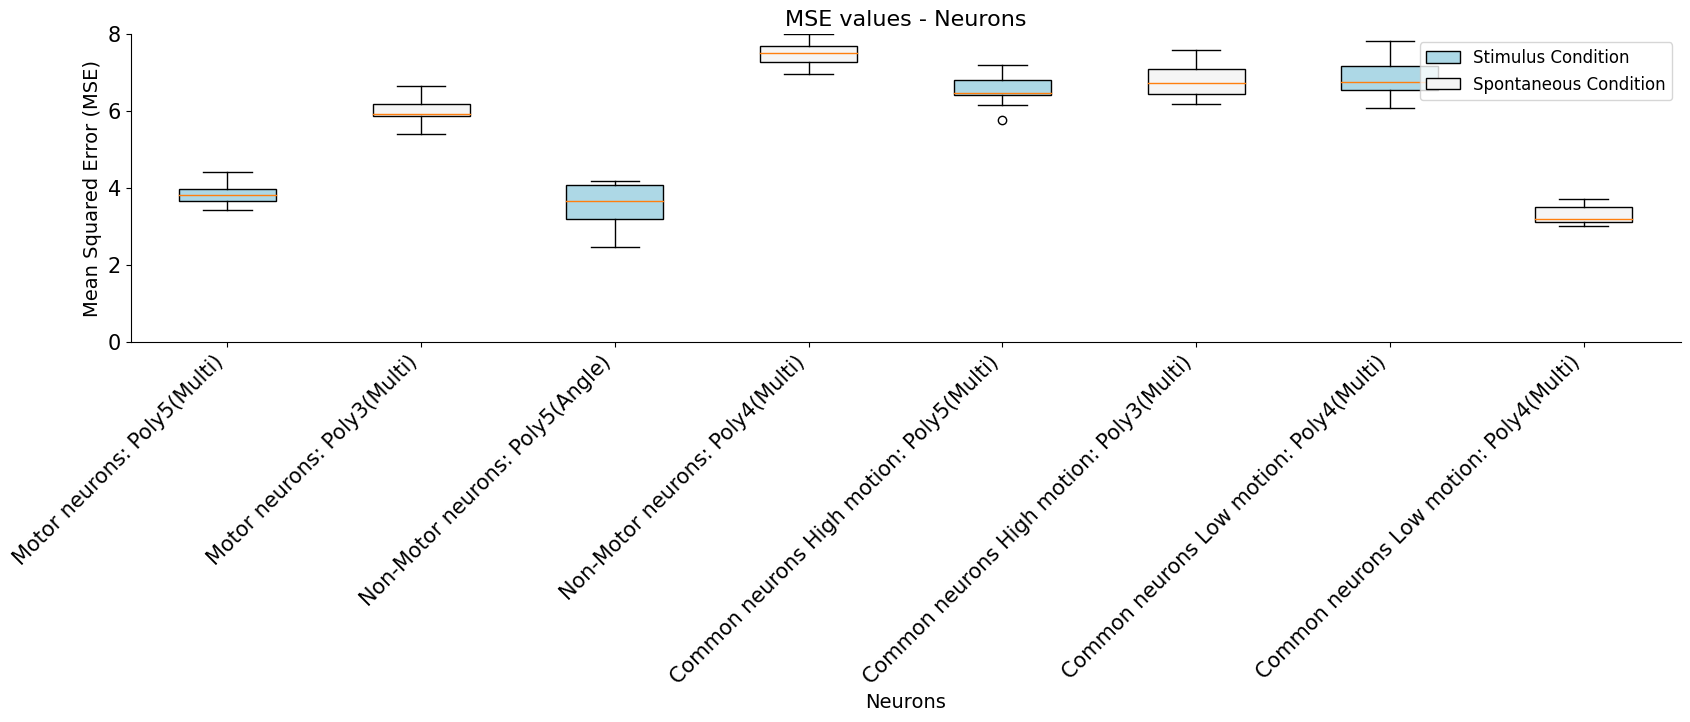

In [ ]:
import matplotlib.pyplot as plt

# Your data
all = [all_mse_values[0], all_mse_values_spont[0], all_mse_values[1], all_mse_values_spont[1],
       all_mse_values[2], all_mse_values_spont[2], all_mse_values[3], all_mse_values_spont[3]]

labels = [labels_stim[0], labels_spont[0], labels_stim[1], labels_spont[1],
          labels_stim[2], labels_spont[2], labels_stim[3], labels_spont[3]]

# Set background color for 'Stimulation' and 'Spontaneous' conditions
background_colors = ['lightblue' if i in [0, 2, 4, 6] else 'whitesmoke' for i in range(len(all))]

# Create a single subplot
fig, ax = plt.subplots(figsize=(20, 4))

# Create boxplot with specified background colors
box = ax.boxplot(all, labels=labels, patch_artist=True, boxprops=dict(facecolor='blue'))

# Customize box colors
for patch, color in zip(box['boxes'], ['blue', 'orange', 'green', 'red']):
    patch.set_facecolor(color)

# Set background color for specific boxplots
for patch, color in zip(box['boxes'], background_colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_xlabel('Neurons', fontsize=14)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
# Rotate x-axis labels
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45, ha='right')
# Set y-limit
ax.set_ylim(0, 8)

# Create custom legend labels
legend_labels = ['Stimulus Condition', 'Spontaneous Condition']
ax.legend([box["boxes"][0], box["boxes"][1]], legend_labels, loc='upper right', fontsize=12)

# Set title
ax.set_title(f'MSE values - Neurons', fontsize=16)

# Display the plot
plt.show()


In [ ]:
#print('Mptor neurons',np.median(mse_motor_poli5_multinput))
#print('Non-Mptor neurons',np.median(mse_non_motor_poli5_angle))


In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Common neurons during High-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_common_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_common_motor)


In [ ]:
print(embed.shape)

(2901, 3)


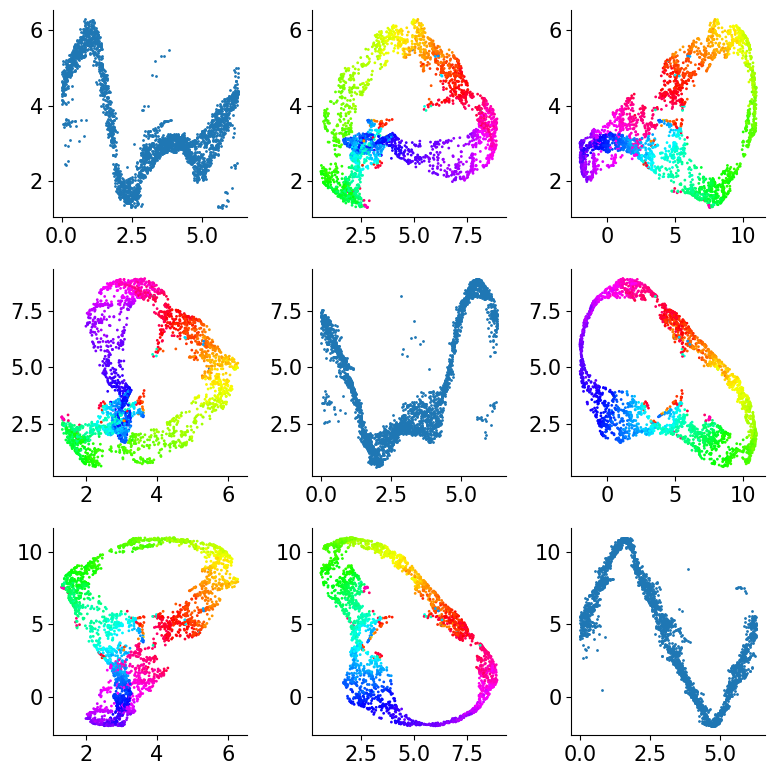

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(high_motion_angle_data, embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=high_motion_angle_data, cmap='hsv')
plt.show()

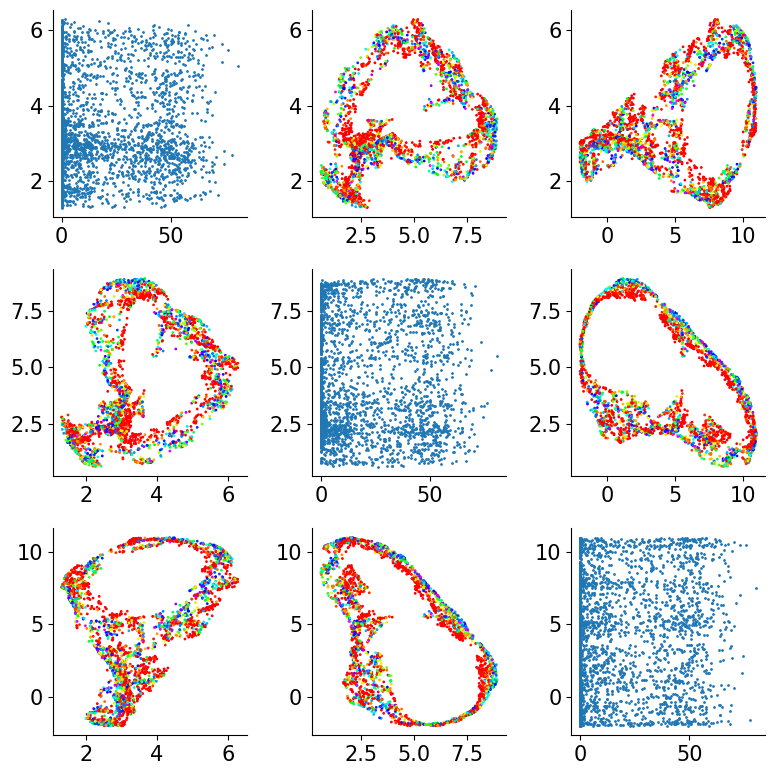

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(high_motion_run_data, embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=high_motion_run_data, cmap='hsv')
plt.show()

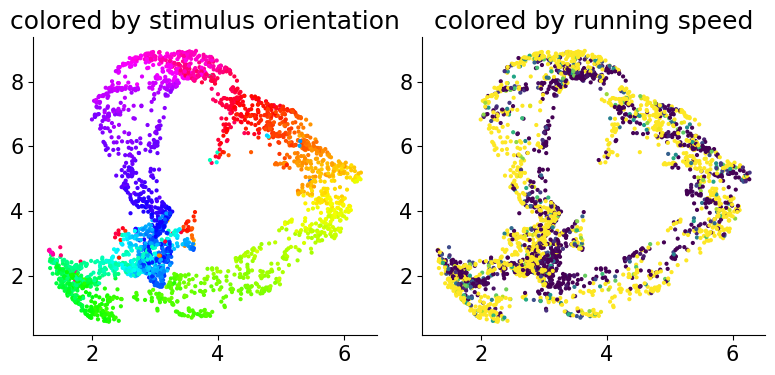

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 0], embed[:, 1], s=4, c=high_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 0], embed[:, 1], s=4, c=high_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Motor neurons during High-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_motor)


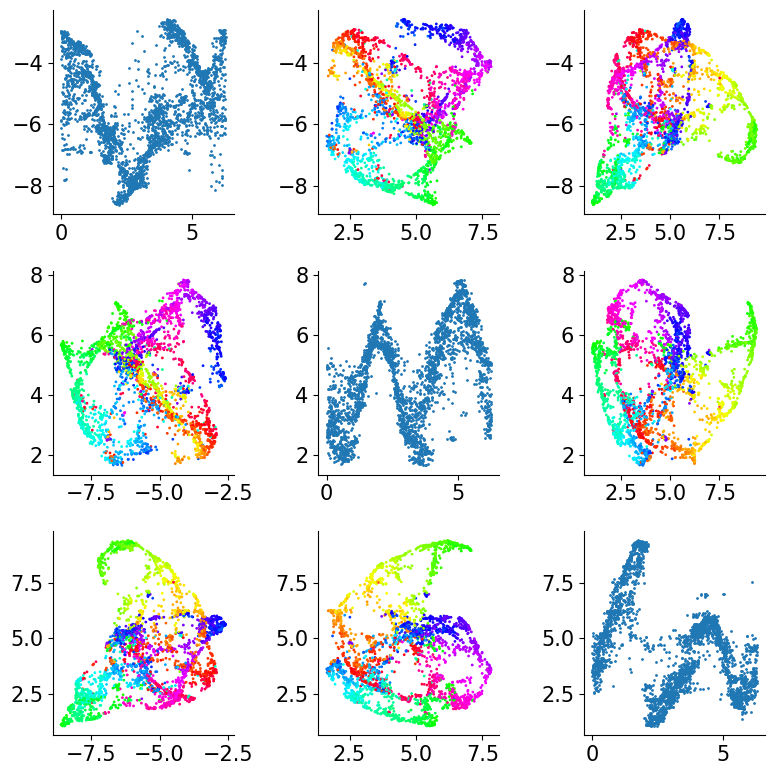

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(high_motion_angle_data, embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=high_motion_angle_data, cmap='hsv')
plt.show()

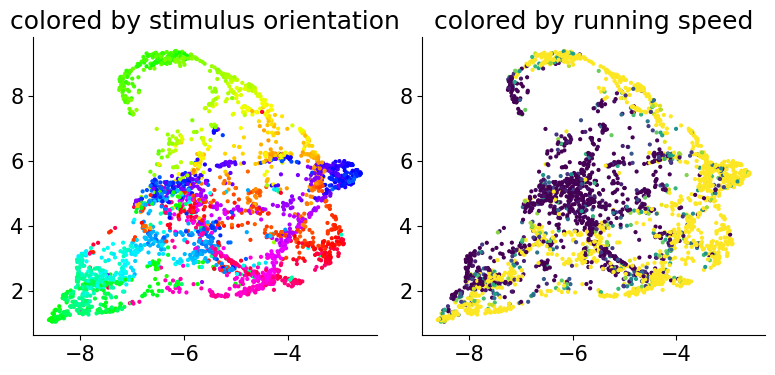

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 0], embed[:, 2], s=4, c=high_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 0], embed[:, 2], s=4, c=high_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Common neurons during Low-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_common_non_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_common_non_motor)


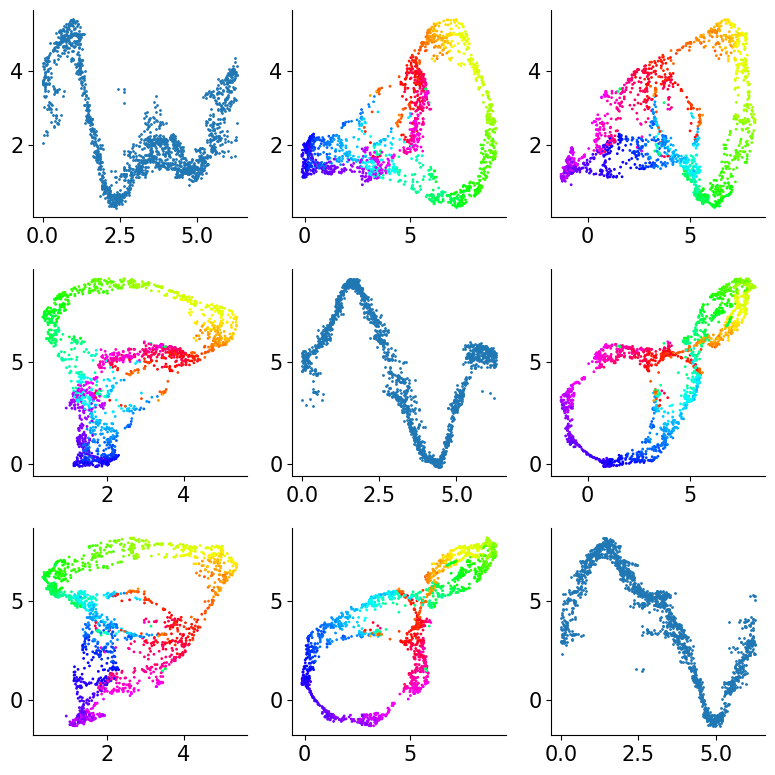

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(non_motion_angle_data , embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=non_motion_angle_data, cmap='hsv')
plt.show()

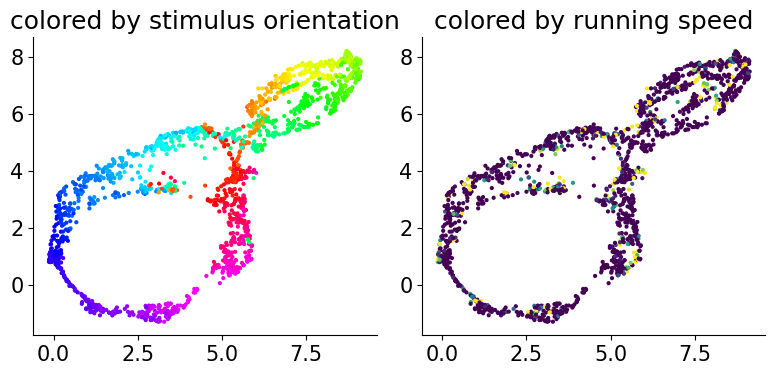

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

(array([1480.,   85.,   51.,   29.,   12.,   18.,    7.,    6.,    5.,
           4.]),
 array([ 0.        ,  4.41249323,  8.82498646, 13.23747921, 17.64997292,
        22.06246567, 26.47495842, 30.88745117, 35.29994583, 39.71243668,
        44.12493134]),
 <BarContainer object of 10 artists>)

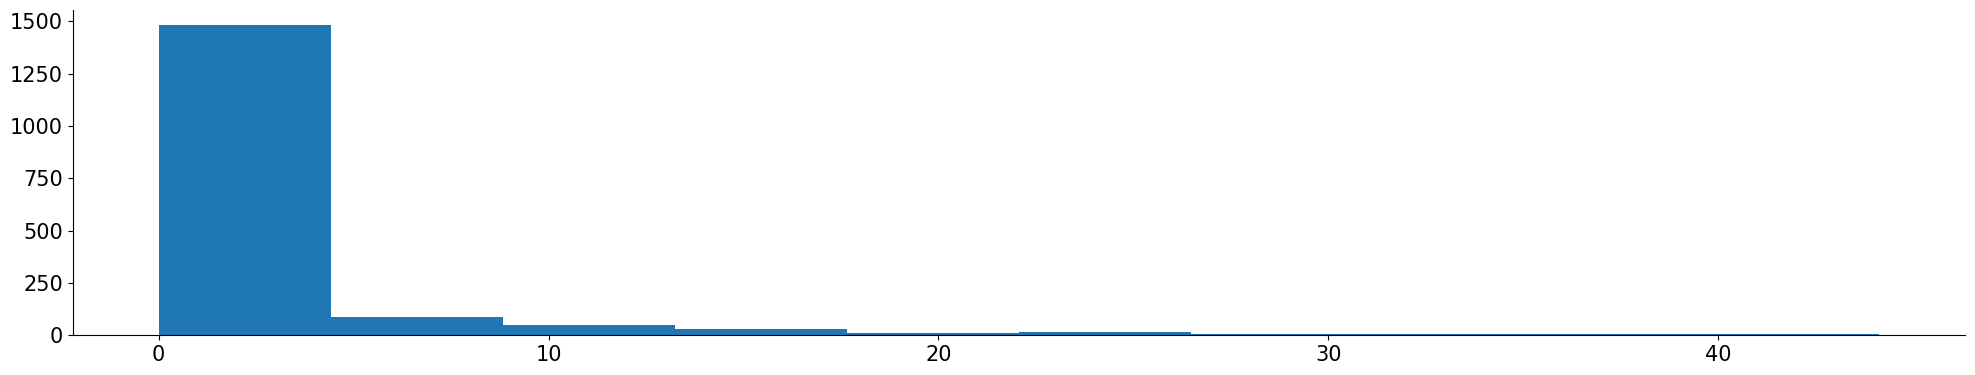

In [ ]:
plt.hist(non_motion_run_data)

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions in Non-motor neurons during Low-motion periods

ncomp = 3  # try 2, then try 3
xinit = 3 * zscore(X_non_motor [:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=25,
             metric='correlation', transform_seed=42).fit_transform(X_non_motor)


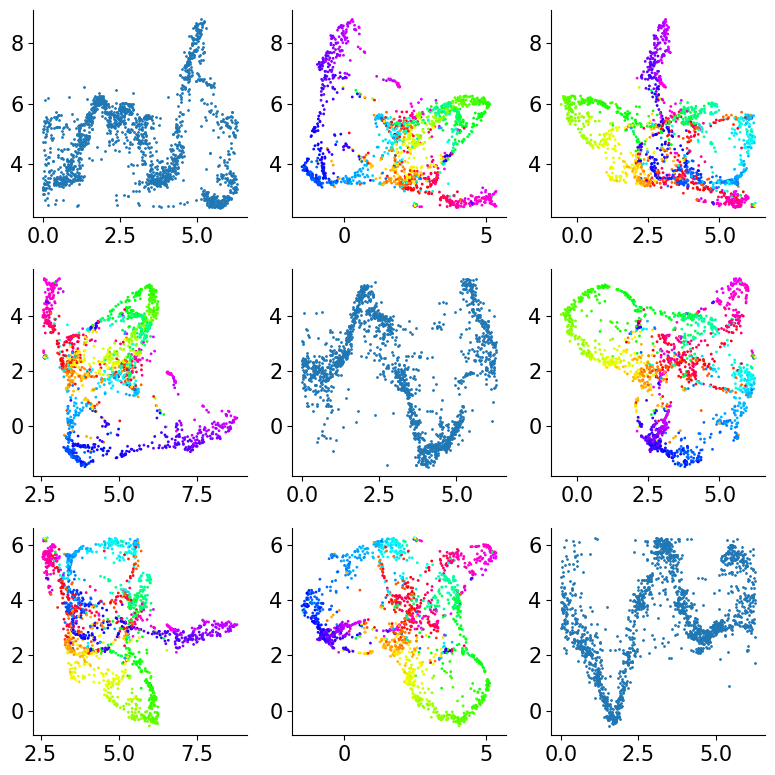

In [ ]:
plt.figure(figsize=(8,8))
for i in range(ncomp):
  for j in range(ncomp):
    plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
    if i == j:
      plt.scatter(non_motion_angle_data , embed[:, i], s=1)
    else:
      plt.scatter(embed[:, j], embed[:, i], s=1, c=non_motion_angle_data, cmap='hsv')
plt.show()

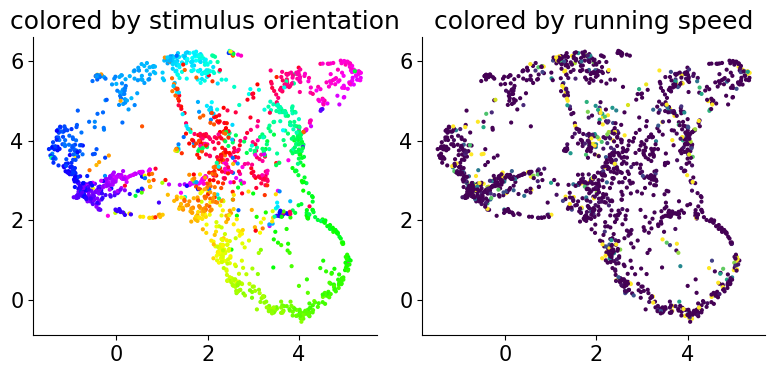

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_angle_data, cmap='hsv')
plt.title('colored by stimulus orientation')

plt.subplot(1, 2, 2)
plt.scatter(embed[:, 1], embed[:, 2], s=4, c=non_motion_run_data, vmin=0, vmax=10)
plt.title('colored by running speed')
plt.show()

Z (104, 1697)
X_non_motor (1697, 70)
pca.components (70, 104)


Text(0.5, 1.0, 'Original')

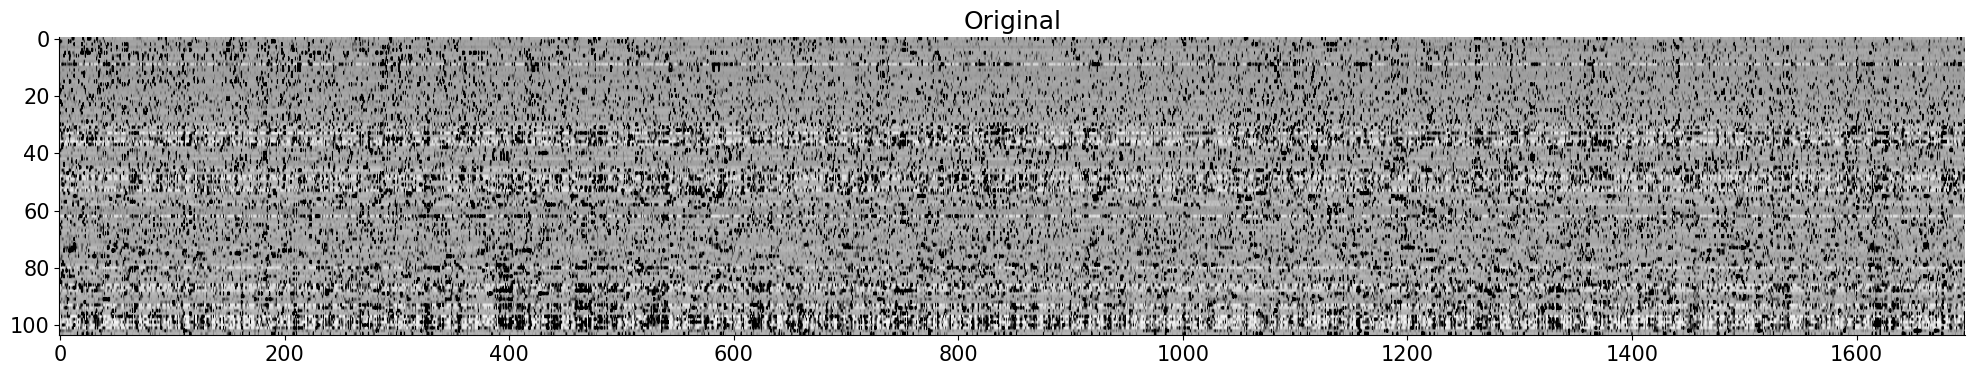

In [ ]:
#Reconstruct neural activity.
#Original neural activity:
Z = zscore(non_motion_neural_data[LMS_neurons_wo_common], axis=1)
#X_non_motor = PCA(n_components=20).fit_transform(Z.T)
# Create and fit the PCA model
pca = PCA(n_components=70)
X_non_motor = pca.fit_transform(Z.T)
print('Z',Z.shape)
print('X_non_motor',X_non_motor.shape)
print('pca.components',pca.components_.shape)
#plt.plot(Z[0,:])
plt.imshow(Z, vmax= 1, vmin=-1, aspect='auto', cmap='gray_r')
plt.title('Original')



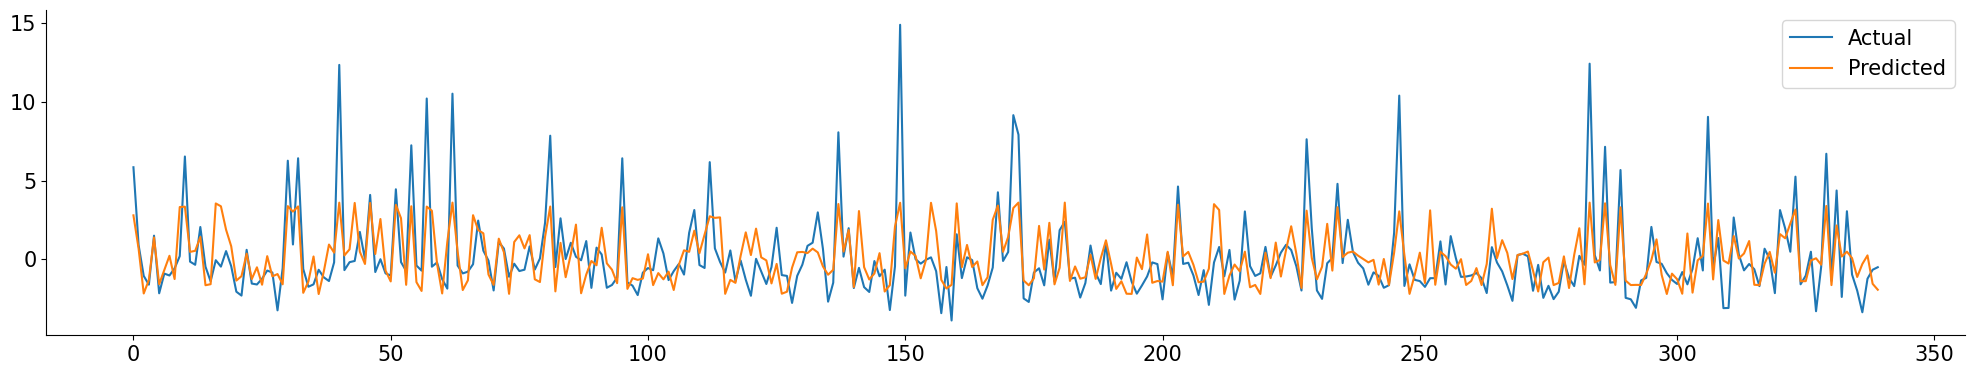

4.084730050821536


In [ ]:
#non_motion_run_data, non_motion_angle_data
non_motion_combined = np.vstack((non_motion_run_data, non_motion_angle_data)).T # Run and angle combined data

#medir actividad aleatoria.
X_train, X_test, y_train, y_test = train_test_split(non_motion_angle_data, X_non_motor_pc,test_size=0.2, random_state=42)
#plt.plot(y_test)

# BEST MODEL WAS: POLY 5 Angle
# Create polynomial features
degree=5
poly = PolynomialFeatures(degree=degree)
X_poly_train = poly.fit_transform(X_train.reshape(-1,1))
X_poly_test = poly.transform(X_test.reshape(-1,1))
# Train linear regression model
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Make predictions
predictions = model.predict(X_poly_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)

plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')

# Add legends
plt.legend()

# Show the plot
plt.show()
print(mse)

(70, 104)
(1, 104)
(340, 1)
(104, 340)


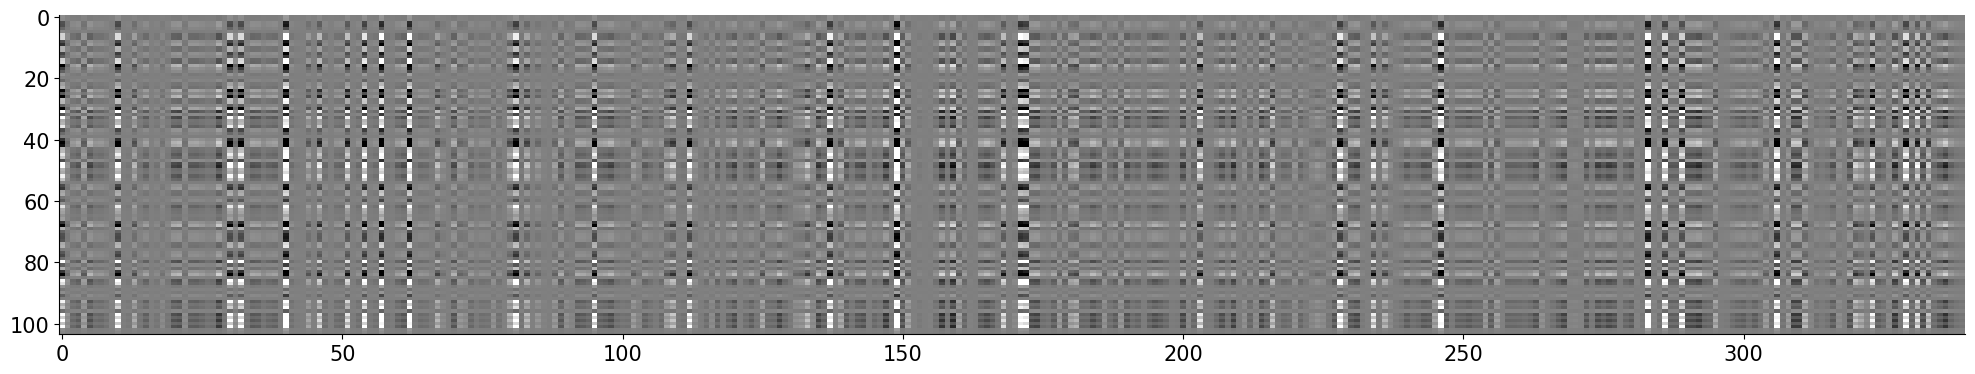

In [ ]:
# @title Recovering neural data from Actual PC
# Recover the original data using dot product
print(pca.components_.shape)
first_principal_component = pca.components_[0, :].reshape(1, -1)
print(first_principal_component.shape)
print(y_test.reshape(-1,1).shape)
recovered_data = np.dot(y_test.reshape(-1,1), first_principal_component).T
print(recovered_data.shape)
plt.imshow(recovered_data, vmax= 1, vmin=-1, aspect='auto', cmap='gray_r')


(70, 104)
(1, 104)
(340, 1)
(104, 340)


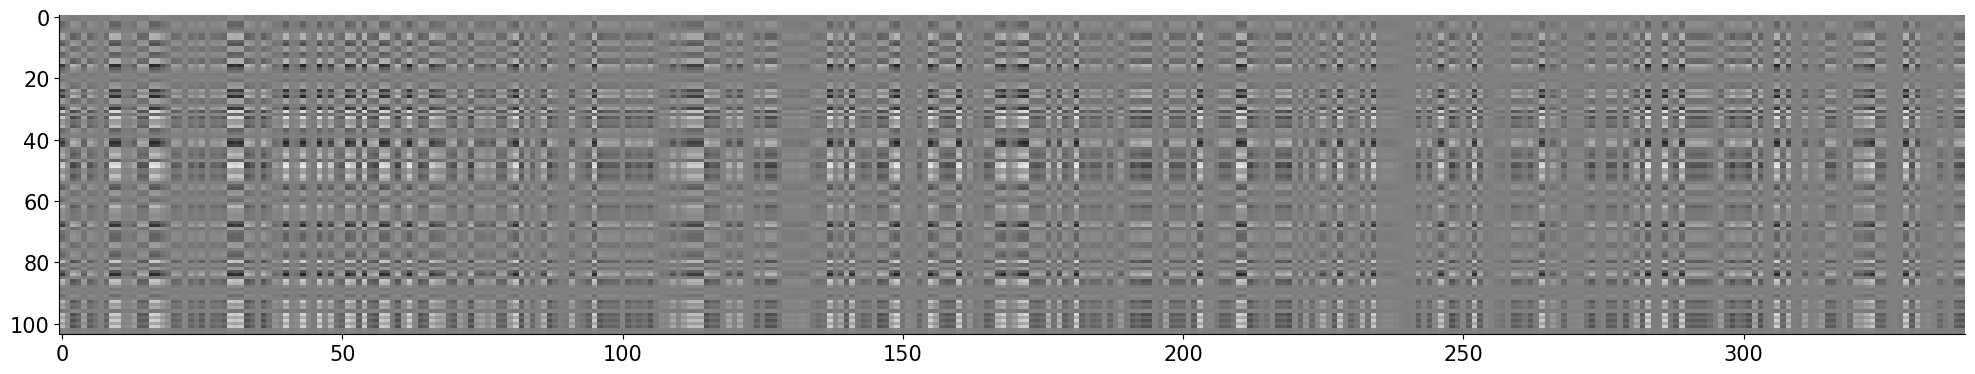

In [ ]:
# @title Recovering neural data from Predicted PC
# Recover the original data using dot product
print(pca.components_.shape)
first_principal_component = pca.components_[0, :].reshape(1, -1)
print(first_principal_component.shape)
print(predictions.reshape(-1,1).shape)
recovered_data = np.dot(predictions.reshape(-1,1), first_principal_component).T
print(recovered_data.shape)
plt.imshow(recovered_data, vmax= 1, vmin=-1, aspect='auto', cmap='gray_r')